In [80]:
import os
import shap
from shap.plots import colors  
import wandb
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import lang2vec.lang2vec as l2v
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from sklearn.tree import plot_tree
from joblib import Parallel, delayed
from scipy.stats import pearsonr, zscore
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.inspection import PartialDependenceDisplay
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics.pairwise import euclidean_distances

# For plots with LaTeX, might give issues depending on your local LaTeX installation
plt.rcParams.update({
    'text.usetex': True,
    'text.latex.preamble': r'\usepackage{amsmath} \usepackage{bm}',
    'font.family': 'serif',
})

In [2]:
language_map = {
    "same": "English",
    "avg": "Average",
    "af": "Afrikaans",
    "ar": "Arabic",
    "bg": "Bulgarian",
    "ca": "Catalan",
    "cs": "Czech",
    "da": "Danish",
    "de": "German",
    "el": "Greek",
    "es": "Spanish",
    "fa": "Persian",
    "fi": "Finnish",
    "fr": "French",
    "he": "Hebrew",
    "hi": "Hindi",
    "hu": "Hungarian",
    "it": "Italian",
    "ja": "Japanese",
    "ko": "Korean",
    "lt": "Lithuanian",
    "lv": "Latvian",
    "no": "Norwegian",
    "pl": "Polish",
    "pt": "Portuguese",
    "ro": "Romanian",
    "ru": "Russian",
    "sk": "Slovak",
    "sl": "Slovenian",
    "sv": "Swedish",
    "ta": "Tamil",
    "th": "Thai",
    "tr": "Turkish",
    "uk": "Ukrainian",
    "vi": "Vietnamese",
    "zh": "Chinese",
    "sw": "Swahili",
    "ur": "Urdu",
    "en": "English"
}

In [3]:
method_names = {
    'baseline': 'Fine-tuning Only',
    'before_fastalign': 'Before FastAlign',
    'before_awesome': 'Before Awesome',
    'before_dico': 'Before Dict',
    'during_fastalign': 'During FastAlign',
    'during_awesome': 'During Awesome',
    'during_dico': 'During Dict',
    'freeze_realign_unfreeze_fastalign': 'Before - Front Freeze FastAlign',
    'freeze_realign_unfreeze_awesome': 'Before - Front Freeze Awesome',
    'freeze_realign_unfreeze_dico': 'Before - Front Freeze Dict',
    'freeze_realign_unfreeze_last_6_fastalign': 'Before - Back Freeze FastAlign',
    'freeze_realign_unfreeze_last_6_awesome': 'Before - Back Freeze Awesome',
    'freeze_realign_unfreeze_last_6_dico': 'Before - Back Freeze Dict',
    'during_partial_freeze_front_fastalign': 'During Front Freeze FastAlign',
    'during_partial_freeze_front_awesome': 'During Front Freeze Awesome',
    'during_partial_freeze_front_dico': 'During Front Freeze Dict',
    'during_partial_freeze_back_fastalign': 'During Back Freeze FastAlign',
    'during_partial_freeze_back_awesome': 'During Back Freeze Awesome',
    'during_partial_freeze_back_dico': 'During Back Freeze Dict',
}

In [4]:
lang2vec_mapping = {
    "English": "eng",
    "Afrikaans": "afr",
    "Arabic": "arb",
    "Bulgarian": "bul",
    "Catalan": "cat",
    "Czech": "ces",
    "Danish": "dan",
    "German": "deu",
    "Greek": "ell",
    "Spanish": "spa",
    "Persian": "fas",
    "Finnish": "fin",
    "French": "fra",
    "Hebrew": "heb",
    "Hindi": "hin",
    "Hungarian": "hun",
    "Italian": "ita",
    "Japanese": "jpn",
    "Korean": "kor",
    "Lithuanian": "lit",
    "Latvian": "lav",
    "Norwegian": "nob",
    "Polish": "pol",
    "Portuguese": "por",
    "Romanian": "ron",
    "Russian": "rus",
    "Slovak": "slk",
    "Slovenian": "slv",
    "Swedish": "swe",
    "Tamil": "tam",
    "Thai": "tha",
    "Turkish": "tur",
    "Ukrainian": "ukr",
    "Vietnamese": "vie",
    "Chinese": "cmn"
}

In [5]:
xlmr_token_data = {
    'Afrikaans': 242,
    'Arabic': 2869,
    'Bulgarian': 5487,
    'Catalan': 1752,
    'Czech': 2498,
    'Danish': 7823,
    'German': 10297,
    'Greek': 4285,
    'Spanish': 9374,
    'Persian': 13259,
    'Finnish': 6730,
    'French': 9780,
    'Hebrew': 3399,
    'Hindi': 1715,
    'Hungarian': 7807,
    'Italian': 4983,
    'Japanese': 530,
    'Korean': 5644,
    'Lithuanian': 1835,
    'Latvian': 1198,
    'Norwegian': 8494,
    'Polish': 6490,
    'Portuguese': 8405,
    'Romanian': 10354,
    'Russian': 23408,
    'Slovak': 3525,
    'Slovenian': 1669,
    'Swedish': 77.8,
    'Tamil': 595,
    'Thai': 1834,
    'Turkish': 2736,
    'Ukrainian': 6.5,
    'Vietnamese': 24757,
    'Chinese': 176
}


In [6]:
id_var_color_map = {
    'Method': 'blue',
    'Languages': 'green',
    'Model': 'purple',
    'QE Percentile': 'orange',
    'QE Threshold': 'red',
    'Distance': 'brown'
}

method_color_map = {
    'Fine-tuning Only': 'blue',
    'Before FastAlign': 'green',
    'Before Awesome': 'red',
    'Before Dict': 'purple',
    'During FastAlign': 'orange',
    'During Awesome': 'brown',
    'During Dict': 'pink',
    'Before - Front Freeze FastAlign': 'olive',
    'Before - Front Freeze Awesome': 'cyan',
    'Before - Front Freeze Dict': 'magenta',
    'Before - Back Freeze FastAlign': 'lime',
    'Before - Back Freeze Awesome': 'teal',
    'Before - Back Freeze Dict': 'lavender',
    'During Front Freeze FastAlign': 'darkgreen',
    'During Front Freeze Awesome': 'darkred',
    'During Front Freeze Dict': 'darkviolet',
    'During Back Freeze FastAlign': 'darkorange',
    'During Back Freeze Awesome': 'saddlebrown',
    'During Back Freeze Dict': 'mediumvioletred'
}

language_names = list(language_map.values())
num_languages = len(language_names)
colors = sns.color_palette("tab20", num_languages).as_hex()
language_color_map = dict(zip(language_names, colors))

distance_color_map = {
    'inventory': 'blue',
    'syntactic': 'green',
    'featural': 'red',
    'geographic': 'purple',
    'phonological': 'orange',
    'genetic': 'brown'
}

value_color_map = {
    '0.0': 'gray',
    '0.4': 'darkblue',
    '0.5': 'darkgreen',
    '0.6': 'darkred',
    '0.7': 'indigo',
    '0.8': 'darkorange',
    '25.0': 'lightgreen',
    '37.0': 'lightcoral',
    '62.0': 'violet',
    '75.0': 'lightblue',
    '50.0': 'lightyellow'
}

In [7]:
def get_lang_distances(lang1, lang2, mapping):
    if lang1 == 'English' and lang2 == 'English':
        return {'syntactic': 0, 'geographic': 0, 'phonological': 0, 'genetic': 0, 'inventory': 0, 'featural': 0}
    lang2_code = mapping.get(lang2)
    
    if not lang2_code:
        print(f"Error: {lang2} is not in the language mapping.")
        return {k: np.nan for k in ['syntactic', 'geographic', 'phonological', 'genetic', 'inventory', 'featural']}
    
    try:
        distances = {
            'syntactic': l2v.distance('syntactic', lang1, lang2_code),
            'geographic': l2v.distance('geographic', lang1, lang2_code),
            'phonological': l2v.distance('phonological', lang1, lang2_code),
            'genetic': l2v.distance('genetic', lang1, lang2_code),
            'inventory': l2v.distance('inventory', lang1, lang2_code),
            'featural': l2v.distance('featural', lang1, lang2_code),
        }
    except Exception as e:
        print(f"Error calculating distances between {lang1} and {lang2_code}: {e}")
        distances = {k: np.nan for k in ['syntactic', 'geographic', 'phonological', 'genetic', 'inventory', 'featural']}
    
    return distances

In [8]:
def add_language_distances_to_df(df, target_lang='eng', lang_col='language'):
    # Initialize distance columns
    distance_cols = ['syntactic', 'geographic', 'phonological', 'genetic', 'inventory', 'featural']
    for col in distance_cols:
        df[col] = np.nan

    for lang in df[lang_col].unique():
        distances = get_lang_distances(target_lang, lang, lang2vec_mapping)
        for col, value in distances.items():
            df.loc[df[lang_col] == lang, col] = value
    
    return df

In [9]:
api = wandb.Api()

workspace = "align_freeze"
projects = ['3nl_34langs_baseline_udpos',
            '3nl_34langs_before_fastalign_udpos',
            '3nl_34langs_before_awesome_udpos',
            '3nl_34langs_before_dico_udpos',
            '3nl_34langs_during_fastalign_udpos',
            '3nl_34langs_during_awesome_udpos',
            '3nl_34langs_during_dico_udpos',
            '3nl_34langs_freeze_realign_unfreeze_fastalign_udpos',
            '3nl_34langs_freeze_realign_unfreeze_awesome_udpos',
            '3nl_34langs_freeze_realign_unfreeze_dico_udpos',
            '3nl_34langs_freeze_realign_unfreeze_last_6_fastalign_udpos',
            '3nl_34langs_freeze_realign_unfreeze_last_6_awesome_udpos',
            '3nl_34langs_freeze_realign_unfreeze_last_6_dico_udpos',
            '3nl_34langs_during_partial_freeze_front_fastalign_udpos',
            '3nl_34langs_during_partial_freeze_front_awesome_udpos',
            '3nl_34langs_during_partial_freeze_front_dico_udpos',
            '3nl_34langs_during_partial_freeze_back_fastalign_udpos',
            '3nl_34langs_during_partial_freeze_back_awesome_udpos',
            '3nl_34langs_during_partial_freeze_back_dico_udpos']

langs = ["same", "avg", "af", "ar", "bg", "ca", "cs", "da", "de", "el", "es", "fa", "fi", "fr", "he", "hi",
         "hu", "it", "ja", "ko", "lt", 'lv', 'no', 'pl', 'pt', 'ro', 'ru', 'sk', 'sl', 'sv', 'ta', 'th', 'tr', 'uk',
         'vi', 'zh']

def fetch_and_process_runs(projects, _langs, model_name, username="felixgaschi"):
    records = []
    
    for project in projects:
        runs = api.runs(f"{workspace}/{project}")
        for run in runs:
            if run.user.username == username:
                method = run.config.get('method', 'unknown')
                seed = run.config.get('seed', 'unknown')
                for lang in _langs:
                    accuracy_key = f"eval_{lang}_accuracy"
                    accuracy = run.summary.get(accuracy_key)
                    record = {
                        'model': model_name,
                        'method': method_names.get(method, method),
                        'language': language_map.get(lang, lang),
                        'seed': seed,
                        'accuracy': accuracy if accuracy is not None else None
                    }
                    records.append(record)
    
    df_records = pd.DataFrame(records)
    return df_records

# Fetching and processing the data for XLM-R
xlmr_df = fetch_and_process_runs(projects, langs, model_name='XLM-R')
xlmr_df

,model,method,language,seed,accuracy
0,XLM-R,Fine-tuning Only,English,17,0.966891
1,XLM-R,Fine-tuning Only,Average,17,0.807267
2,XLM-R,Fine-tuning Only,Afrikaans,17,0.882861
3,XLM-R,Fine-tuning Only,Arabic,17,0.622334
4,XLM-R,Fine-tuning Only,Bulgarian,17,0.887179
...,...,...,...,...,...
3595,XLM-R,During Back Freeze Dict,Thai,31,0.686990
3596,XLM-R,During Back Freeze Dict,Turkish,31,0.726260
3597,XLM-R,During Back Freeze Dict,Ukrainian,31,0.854369
3598,XLM-R,During Back Freeze Dict,Vietnamese,31,0.643915


In [10]:
csv_file_path = './distilMBERT_percentile_data/distilbert-base-multilingual-cased__opus100.csv'

def read_and_process_csv(file_path, model_name):
    df = pd.read_csv(file_path)
    records = []
    
    for idx, row in df.iterrows():
        method = row['method']
        seed = row['seed']
        for lang in language_map.keys():
            accuracy_key = f'eval_{lang}_accuracy'
            if accuracy_key in df.columns:
                accuracy = row[accuracy_key]
                record = {
                    'model': model_name,
                    'method': method_names.get(method, method),
                    'language': language_map.get(lang, lang),
                    'seed': seed,
                    'accuracy': accuracy if not pd.isna(accuracy) else None
                }
                records.append(record)
    
    df_records = pd.DataFrame(records)
    return df_records

distilmbert_df = read_and_process_csv(csv_file_path, model_name='distilMBERT')


In [11]:
# xlmr_csv_path = './xlmr_threshold_data/xlm-roberta-base__opus100.csv'

# xlmr_df = read_and_process_csv(xlmr_csv_path, model_name='XLM-R')

In [12]:
distilmbert_df['method'].value_counts()

method
Before FastAlign                               180
Before Awesome                                 180
Before Dict                                    180
During FastAlign                               180
During Awesome                                 180
During Dict                                    180
Before - Front Freeze FastAlign                180
Before - Front Freeze Awesome                  180
Before - Front Freeze Dict                     180
During Front Freeze FastAlign                  180
During Front Freeze Awesome                    180
During Front Freeze Dict                       180
During Back Freeze FastAlign                   180
During Back Freeze Awesome                     180
During Back Freeze Dict                        180
Fine-tuning Only                               180
freeze_realign_unfreeze_last_half_fastalign    180
freeze_realign_unfreeze_last_half_awesome      180
freeze_realign_unfreeze_last_half_dico         180
Name: count, dtype: int6

In [13]:
xlmr_df['method'].value_counts()

method
Before FastAlign                   360
Fine-tuning Only                   180
Before Awesome                     180
Before Dict                        180
During FastAlign                   180
During Awesome                     180
During Dict                        180
Before - Front Freeze FastAlign    180
Before - Front Freeze Awesome      180
Before - Front Freeze Dict         180
Before - Back Freeze FastAlign     180
Before - Back Freeze Awesome       180
Before - Back Freeze Dict          180
During Front Freeze FastAlign      180
During Front Freeze Awesome        180
During Front Freeze Dict           180
During Back Freeze FastAlign       180
During Back Freeze Awesome         180
During Back Freeze Dict            180
Name: count, dtype: int64

In [14]:
xlmr_df[(xlmr_df['method'] == 'Before FastAlign') & (xlmr_df['language'] == 'Chinese')]

,model,method,language,seed,accuracy
215,XLM-R,Before FastAlign,Chinese,17,0.709648
251,XLM-R,Before FastAlign,Chinese,23,0.707151
287,XLM-R,Before FastAlign,Chinese,66,0.707650
323,XLM-R,Before FastAlign,Chinese,42,0.699992
359,XLM-R,Before FastAlign,Chinese,31,0.700491
395,XLM-R,Before FastAlign,Chinese,31,NaN
431,XLM-R,Before FastAlign,Chinese,23,NaN
467,XLM-R,Before FastAlign,Chinese,66,NaN
503,XLM-R,Before FastAlign,Chinese,42,NaN
539,XLM-R,Before FastAlign,Chinese,31,NaN


In [15]:
xlmr_df = xlmr_df[~xlmr_df.isna().any(axis=1)]
xlmr_df

,model,method,language,seed,accuracy
0,XLM-R,Fine-tuning Only,English,17,0.966891
1,XLM-R,Fine-tuning Only,Average,17,0.807267
2,XLM-R,Fine-tuning Only,Afrikaans,17,0.882861
3,XLM-R,Fine-tuning Only,Arabic,17,0.622334
4,XLM-R,Fine-tuning Only,Bulgarian,17,0.887179
...,...,...,...,...,...
3595,XLM-R,During Back Freeze Dict,Thai,31,0.686990
3596,XLM-R,During Back Freeze Dict,Turkish,31,0.726260
3597,XLM-R,During Back Freeze Dict,Ukrainian,31,0.854369
3598,XLM-R,During Back Freeze Dict,Vietnamese,31,0.643915


In [16]:
xlmr_df['method'].value_counts()

method
Fine-tuning Only                   180
Before FastAlign                   180
Before Awesome                     180
Before Dict                        180
During FastAlign                   180
During Awesome                     180
During Dict                        180
Before - Front Freeze FastAlign    180
Before - Front Freeze Awesome      180
Before - Front Freeze Dict         180
Before - Back Freeze FastAlign     180
Before - Back Freeze Awesome       180
Before - Back Freeze Dict          180
During Front Freeze FastAlign      180
During Front Freeze Awesome        180
During Front Freeze Dict           180
During Back Freeze FastAlign       180
During Back Freeze Awesome         180
During Back Freeze Dict            180
Name: count, dtype: int64

In [17]:
assert len(xlmr_df) == len(distilmbert_df)

In [18]:
def calculate_delta_accuracy(group):
    baseline = group[group['method'] == 'Fine-tuning Only']
    methods = group[group['method'] != 'Fine-tuning Only']
    
    if len(baseline) > 0:
        baseline_accuracy = baseline['accuracy'].values
        
        for method in methods['method'].unique():
            method_indices = methods['method'] == method
            baseline_subset = baseline_accuracy[:sum(method_indices)]
            methods.loc[method_indices, 'delta_accuracy'] = methods.loc[method_indices, 'accuracy'].values - baseline_subset

    return pd.concat([baseline, methods])

def process_dataframe(df, group_by_columns):
    result = df.groupby(group_by_columns, group_keys=False).apply(calculate_delta_accuracy)
    return result.reset_index(drop=True)

In [19]:
processed_distilmbert_df = process_dataframe(distilmbert_df, group_by_columns=['model', 'seed', 'language'])
processed_distilmbert_df

/tmp/ipykernel_234038/2421398949.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result = df.groupby(group_by_columns, group_keys=False).apply(calculate_delta_accuracy)


,model,method,language,seed,accuracy,delta_accuracy
0,distilMBERT,Fine-tuning Only,Afrikaans,17,0.852558,NaN
1,distilMBERT,Before FastAlign,Afrikaans,17,0.866965,0.014406
2,distilMBERT,Before Awesome,Afrikaans,17,0.865176,0.012618
3,distilMBERT,Before Dict,Afrikaans,17,0.854645,0.002086
4,distilMBERT,During FastAlign,Afrikaans,17,0.862394,0.009836
...,...,...,...,...,...,...
3415,distilMBERT,During Back Freeze Awesome,Vietnamese,66,0.569218,-0.010874
3416,distilMBERT,During Back Freeze Dict,Vietnamese,66,0.586951,0.006859
3417,distilMBERT,freeze_realign_unfreeze_last_half_fastalign,Vietnamese,66,0.570724,-0.009368
3418,distilMBERT,freeze_realign_unfreeze_last_half_awesome,Vietnamese,66,0.576746,-0.003346


In [20]:
processed_distilmbert_df[(processed_distilmbert_df['language'] == 'Chinese') & (processed_distilmbert_df['seed'] == 17)]

,model,method,language,seed,accuracy,delta_accuracy
95,distilMBERT,Fine-tuning Only,Chinese,17,0.650433,NaN
96,distilMBERT,Before FastAlign,Chinese,17,0.656011,0.005578
97,distilMBERT,Before Awesome,Chinese,17,0.658342,0.007909
98,distilMBERT,Before Dict,Chinese,17,0.670163,0.019730
99,distilMBERT,During FastAlign,Chinese,17,0.646187,-0.004246
100,distilMBERT,During Awesome,Chinese,17,0.651349,0.000916
101,distilMBERT,During Dict,Chinese,17,0.655678,0.005245
102,distilMBERT,Before - Front Freeze FastAlign,Chinese,17,0.663004,0.012571
103,distilMBERT,Before - Front Freeze Awesome,Chinese,17,0.661755,0.011322
104,distilMBERT,Before - Front Freeze Dict,Chinese,17,0.666334,0.015901


In [21]:
processed_xlmr_df = process_dataframe(xlmr_df, group_by_columns=['model', 'seed', 'language'])
processed_xlmr_df

/tmp/ipykernel_234038/2421398949.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result = df.groupby(group_by_columns, group_keys=False).apply(calculate_delta_accuracy)


,model,method,language,seed,accuracy,delta_accuracy
0,XLM-R,Fine-tuning Only,English,17,0.966891,NaN
1,XLM-R,Fine-tuning Only,Average,17,0.807267,NaN
2,XLM-R,Fine-tuning Only,Afrikaans,17,0.882861,NaN
3,XLM-R,Fine-tuning Only,Arabic,17,0.622334,NaN
4,XLM-R,Fine-tuning Only,Bulgarian,17,0.887179,NaN
...,...,...,...,...,...,...
3415,XLM-R,During Back Freeze Dict,Thai,31,0.686990,-0.005779
3416,XLM-R,During Back Freeze Dict,Turkish,31,0.726260,0.008068
3417,XLM-R,During Back Freeze Dict,Ukrainian,31,0.854369,-0.004256
3418,XLM-R,During Back Freeze Dict,Vietnamese,31,0.643915,-0.004517


In [22]:
processed_xlmr_df[(processed_xlmr_df['language'] == 'Vietnamese') & (processed_xlmr_df['seed'] == 17)]

,model,method,language,seed,accuracy,delta_accuracy
34,XLM-R,Fine-tuning Only,Vietnamese,17,0.640652,NaN
214,XLM-R,Before FastAlign,Vietnamese,17,0.641907,0.001255
394,XLM-R,Before Awesome,Vietnamese,17,0.643998,0.003346
574,XLM-R,Before Dict,Vietnamese,17,0.642074,0.001422
754,XLM-R,During FastAlign,Vietnamese,17,0.639063,-0.001589
934,XLM-R,During Awesome,Vietnamese,17,0.637892,-0.002760
1114,XLM-R,During Dict,Vietnamese,17,0.646340,0.005688
1294,XLM-R,Before - Front Freeze FastAlign,Vietnamese,17,0.647679,0.007026
1474,XLM-R,Before - Front Freeze Awesome,Vietnamese,17,0.648097,0.007445
1654,XLM-R,Before - Front Freeze Dict,Vietnamese,17,0.651777,0.011125


In [23]:
# Combine the two DataFrames
combined_df = pd.concat([processed_xlmr_df, processed_distilmbert_df], ignore_index=True)

# Drop rows with NaNs in 'accuracy' column
combined_df.dropna(subset=['accuracy'], inplace=True)

# Drop rows with NaNs in 'delta_accuracy' column (if applicable)
combined_df.dropna(subset=['delta_accuracy'], inplace=True)

combined_df

,model,method,language,seed,accuracy,delta_accuracy
180,XLM-R,Before FastAlign,English,17,0.968070,0.001180
181,XLM-R,Before FastAlign,Average,17,0.807816,0.000549
182,XLM-R,Before FastAlign,Afrikaans,17,0.885544,0.002683
183,XLM-R,Before FastAlign,Arabic,17,0.667102,0.044768
184,XLM-R,Before FastAlign,Bulgarian,17,0.891694,0.004515
...,...,...,...,...,...,...
6835,distilMBERT,During Back Freeze Awesome,Vietnamese,66,0.569218,-0.010874
6836,distilMBERT,During Back Freeze Dict,Vietnamese,66,0.586951,0.006859
6837,distilMBERT,freeze_realign_unfreeze_last_half_fastalign,Vietnamese,66,0.570724,-0.009368
6838,distilMBERT,freeze_realign_unfreeze_last_half_awesome,Vietnamese,66,0.576746,-0.003346


In [24]:
# # Calculate average and standard error of delta accuracy grouped by method and model
# average_delta_accuracy = combined_df.groupby(['model', 'method'])['delta_accuracy'].agg(['mean', 'sem']).reset_index()

# # Set up the plot
# fig, ax = plt.subplots(figsize=(12, 6))

# # Define colors for each model
# model_colors = {'XLM-R': '#1f77b4', 'distilMBERT': '#ff7f0e'}

# # Create a multi-level index for the x-axis
# x = list(average_delta_accuracy['method'].unique())
# num_methods = len(x)
# num_models = len(average_delta_accuracy['model'].unique())
# x_pos = np.arange(num_methods)
# width = 0.35

# # Plot bars for each model
# for i, model in enumerate(average_delta_accuracy['model'].unique()):
#     model_data = average_delta_accuracy[average_delta_accuracy['model'] == model]
#     ax.bar(x_pos + i * width, model_data['mean'], width, yerr=model_data['sem'], label=model, color=model_colors[model])

# # Set the x-axis tick positions and labels
# ax.set_xticks(x_pos + width / 2)
# ax.set_xticklabels([method.replace('_', ' ') for method in x], rotation=45, ha='right')

# # Set the plot title and labels
# ax.set_title('Average Delta Accuracy by Method and Model for PoS Tagging')
# ax.set_xlabel('Method')
# ax.set_ylabel('Average Delta Accuracy')

# # Add a legend
# ax.legend(title='Model')

# # Add grid lines
# ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# # Improve the layout
# plt.tight_layout()

# # Show the plot
# plt.show()

In [25]:
from sklearn.model_selection import train_test_split

def split_train_val_test(combined_data, use_standard_split=False, exclude_languages=False, test_size=0.2, val_size=0.1, random_state=42):
    combined_data = combined_data.drop(columns=['accuracy'])

    if use_standard_split:
        if exclude_languages:
            # Get a list of unique languages
            languages = combined_data['language'].unique()
            # Randomly choose languages to exclude from the training set
            val_test_languages = np.random.choice(languages, size=int(len(languages) * (val_size + test_size)), replace=False)
            val_languages = val_test_languages[:int(len(val_test_languages) * (val_size / (val_size + test_size)))]
            test_languages = val_test_languages[int(len(val_test_languages) * (val_size / (val_size + test_size))):]
            
            # Split data accordingly
            train_data = combined_data[~combined_data['language'].isin(val_test_languages)]
            val_data = combined_data[combined_data['language'].isin(val_languages)]
            test_data = combined_data[combined_data['language'].isin(test_languages)]
        else:
            # Perform a standard train-validation-test split
            train_data, temp_data = train_test_split(combined_data, test_size=(test_size + val_size), random_state=random_state)
            val_data, test_data = train_test_split(temp_data, test_size=(test_size / (test_size + val_size)), random_state=random_state)
    else:
        # Perform the split based on seeds
        seeds = combined_data['seed'].unique()
        if len(seeds) < 5:
            raise ValueError("There should be at least 5 unique seeds in the data.")
        
        train_seeds = seeds[:3]
        val_seed = seeds[3]
        test_seed = seeds[4]
        
        train_data = combined_data[combined_data['seed'].isin(train_seeds)]
        val_data = combined_data[combined_data['seed'] == val_seed]
        test_data = combined_data[combined_data['seed'] == test_seed]
    
    train_data = train_data.drop(columns=['seed'])
    val_data = val_data.drop(columns=['seed'])
    test_data = test_data.drop(columns=['seed'])
    
    return train_data.reset_index(drop=True), val_data.reset_index(drop=True), test_data.reset_index(drop=True)

train_data, val_data, test_data = split_train_val_test(combined_df, use_standard_split=True, exclude_languages=True)

train_data


,model,method,language,delta_accuracy
0,XLM-R,Before FastAlign,Average,0.000549
1,XLM-R,Before FastAlign,Arabic,0.044768
2,XLM-R,Before FastAlign,Czech,0.016238
3,XLM-R,Before FastAlign,Danish,-0.001197
4,XLM-R,Before FastAlign,German,0.009659
...,...,...,...,...
4675,distilMBERT,During Back Freeze Awesome,Vietnamese,-0.010874
4676,distilMBERT,During Back Freeze Dict,Vietnamese,0.006859
4677,distilMBERT,freeze_realign_unfreeze_last_half_fastalign,Vietnamese,-0.009368
4678,distilMBERT,freeze_realign_unfreeze_last_half_awesome,Vietnamese,-0.003346


In [26]:
val_data

,model,method,language,delta_accuracy
0,XLM-R,Before FastAlign,Afrikaans,0.002683
1,XLM-R,Before FastAlign,Hindi,0.013999
2,XLM-R,Before FastAlign,Korean,-0.025692
3,XLM-R,Before FastAlign,Afrikaans,-0.000298
4,XLM-R,Before FastAlign,Hindi,0.033136
...,...,...,...,...
535,distilMBERT,During Back Freeze Awesome,Korean,0.050784
536,distilMBERT,During Back Freeze Dict,Korean,0.086580
537,distilMBERT,freeze_realign_unfreeze_last_half_fastalign,Korean,0.025606
538,distilMBERT,freeze_realign_unfreeze_last_half_awesome,Korean,0.049927


In [27]:
test_data

,model,method,language,delta_accuracy
0,XLM-R,Before FastAlign,English,0.001180
1,XLM-R,Before FastAlign,Bulgarian,0.004515
2,XLM-R,Before FastAlign,Catalan,0.000534
3,XLM-R,Before FastAlign,Spanish,0.002527
4,XLM-R,Before FastAlign,Persian,-0.021532
...,...,...,...,...
1255,distilMBERT,During Back Freeze Awesome,Spanish,0.005054
1256,distilMBERT,During Back Freeze Dict,Spanish,0.006929
1257,distilMBERT,freeze_realign_unfreeze_last_half_fastalign,Spanish,0.011656
1258,distilMBERT,freeze_realign_unfreeze_last_half_awesome,Spanish,0.013694


In [28]:
def plot_loss_curve(errors, save_path=None, start=1, end=None, title=""):
    if end is None:
        end = len(errors)
    plt.figure(figsize=(10, 6))
    plt.plot(range(start, end + 1), errors[start - 1:end], marker='o')
    plt.title(f'Model Loss Over Time - {title}')
    plt.xlabel('Number of Trees')
    plt.ylabel('Mean Squared Error')
    plt.grid(True)
    if save_path:
        plt.savefig(os.path.join(save_path, f'loss_curve_{title.replace(" ", "_")}.png'))
    else:
        plt.show()
    plt.close()

In [29]:
def calculate_shap_values(explainer, X, approximate=False):
    return explainer.shap_values(X, approximate=approximate)

In [68]:
def plot_shap_summary(model, X, save_path=None, title="", use_linear_regressor=False):
    if use_linear_regressor:
        explainer = shap.LinearExplainer(model, X, feature_perturbation="correlation_dependent")
        shap_values = explainer.shap_values(X)
    else:
        explainer = shap.TreeExplainer(model)
        # Use Parallel processing to speed up SHAP value calculation
        n_jobs = -1  # Use all available CPU cores
        shap_values = Parallel(n_jobs=n_jobs, backend='loky')(
            delayed(calculate_shap_values)(explainer, X.iloc[i:i+1], approximate=False)
            for i in tqdm(range(X.shape[0]), desc="Calculating SHAP values")
        )
        shap_values = np.vstack(shap_values)
    
    # Rename columns for better readability
    X_renamed = X.copy()
    X_renamed.columns = [
        col.replace('_', ' ').title()
        if col.startswith("language") else
        f"Distance {col.replace('_', ' ').title()}"
        if col in ["inventory", "featural", "syntactic", "geographic", "phonological", "genetic"] else
        f"Method {method_names.get(col.removeprefix('method_'), col.removeprefix('method_')).replace('_', ' ').title()}"
        if col.startswith("method_") else
        col.replace('_', ' ').title()
        for col in X.columns
    ]
    # Try to keep it short
    X_renamed.columns = [
        col.replace("Method", "")
        .replace("Language", "")
        .replace("Model", "")
        .replace("Families", "")
        .replace("Distance", "")
        .replace("-", "")
        .replace("  ", " ")
        .strip()
        for col in X_renamed.columns
    ]
    # This saves a lot of space
    X_renamed.columns = [
        col.replace("During Back", "During Back\n")
        .replace("During Front", "During Front\n")
        .replace("Before Back", "Before Back\n")
        .replace("Before Front", "Before Front\n")
        for col in X_renamed.columns
    ]
    # A few small details
    X_renamed.columns = [
        col.replace("XlmR", "XLM-R")
        .replace("Distilmbert", "DistilMBERT")
        .replace("Awesome", "AwesomeAlign")
        .replace("Fastalign", "FastAlign")
        for col in X_renamed.columns
    ]
    # Shorten aligner names
    X_renamed.columns = [
        col.replace("FastAlign", "FA")
        .replace("AwesomeAlign", "AA")
        .replace("Dict", "BD")
        for col in X_renamed.columns
    ]
    plt.figure()
    shap.summary_plot(
        shap_values, 
        X_renamed, 
        show=False, 
        axis_color="#000000", 
        alpha=0.2,
        # cmap=colors.red_blue,
        cmap=LinearSegmentedColormap.from_list("custom", ["#F8A111", "#1168F8"])
    )

    plt.xlabel(r"\textbf{SHAP value (impact on model output)}", fontsize=16, labelpad=10)
    plt.ylabel(r"\textbf{Features}", fontsize=16, labelpad=10)

    plt.tick_params(axis='y', labelsize=16)
    plt.tick_params(axis='x', labelsize=16)

    cbar = plt.gcf().axes[-1] 
    cbar.set_ylabel(r'\textbf{Feature value}', fontsize=16, rotation=270)
    cbar.tick_params(labelsize=16) 

    plt.grid()

    if save_path:
        plt.savefig(os.path.join(save_path, 'shap_summary.pdf'), bbox_inches="tight")

    plt.show()
    plt.close()

In [31]:
def plot_feature_importances(coefficients, encoded_columns, group_by_distance=False, title=""):
    # Helper function to remove prefix from text
    def remove_prefix(text, prefixes):
        for prefix in prefixes:
            if text.startswith(prefix):
                return text[len(prefix):]
        return text

    def titleize(text):
        return text.title()

    # Create a DataFrame from coefficients and encoded columns
    importances_df = pd.DataFrame({'Feature': encoded_columns, 'Importance': coefficients})
    importances_df = importances_df.sort_values(by='Importance', ascending=False)
    
    prefixes = ['Families_', 'method_', 'language_', 'model_']
    
    importances_df['Group'] = importances_df['Feature'].apply(
        lambda x: 'Distance' if x == 'Distance'
        else ('Family' if 'Families' in x 
        else ('Method' if 'method' in x 
        else ('Language' if 'language' in x 
        else 'Model')))
    )
    
    plt.figure(figsize=(12, 10))
    # sns.set(style="whitegrid")
    ax = sns.barplot(x='Importance', y='Feature', hue='Group', data=importances_df, dodge=False)
    
    # Update y-axis labels to remove prefixes and titleize distances
    new_labels = [titleize(remove_prefix(label.get_text(), prefixes)) for label in ax.get_yticklabels()]
    ax.set_yticklabels(new_labels)
    
    plt.title(f'Feature Importances - {title}', fontsize=16)
    plt.xlabel('Importance', fontsize=14)
    plt.ylabel('Feature', fontsize=14)
    plt.legend(title='Group', loc='upper right', fontsize=12)
    
    plt.tight_layout()
    plt.show()

In [32]:
def plot_actual_vs_predicted(y_true, y_pred, title=""):
    # Calculate R2 score and MSE
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred, alpha=0.5, label='Predicted vs Actual')
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--', label='Ideal Fit')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Actual vs. Predicted Values {title}')
    
    # Move the legend to the lower right
    plt.legend(loc='lower right')
    
    # Place the R2 and MSE scores in the top left corner of the plot
    plt.text(0.05, 0.95, f'R²: {r2:.4f}\nMSE: {mse:.4f}', 
             transform=plt.gca().transAxes, 
             verticalalignment='top', 
             bbox=dict(boxstyle='round,pad=0.5', edgecolor='gray', facecolor='white'))
    
    plt.grid(True)
    plt.show()

In [33]:
def perform_regression(train_data, val_data, test_data, use_linear_regressor=False, n_estimators=30, save_path=None, title=""):
    # Encode categorical variables
    encoded_train_df = pd.get_dummies(train_data, drop_first=False)
    encoded_val_df = pd.get_dummies(val_data, drop_first=False)
    encoded_test_df = pd.get_dummies(test_data, drop_first=False)
    
    # Ensure the encoded validation and test sets have the same columns as the training set
    encoded_val_df = encoded_val_df.reindex(columns=encoded_train_df.columns, fill_value=0)
    encoded_test_df = encoded_test_df.reindex(columns=encoded_train_df.columns, fill_value=0)
    
    X_train = encoded_train_df.drop('delta_accuracy', axis=1)
    y_train = encoded_train_df['delta_accuracy']
    X_val = encoded_val_df.drop('delta_accuracy', axis=1)
    y_val = encoded_val_df['delta_accuracy']
    X_test = encoded_test_df.drop('delta_accuracy', axis=1)
    y_test = encoded_test_df['delta_accuracy']
    
    if use_linear_regressor:
        regression_model = LinearRegression()
        regression_model.fit(X_train, y_train)
        y_pred = regression_model.predict(X_val)
        val_mse = mean_squared_error(y_val, y_pred)
        print(f"\nValidation MSE for {title} (Linear Regression): {val_mse}")
        
        importances = regression_model.coef_
        coefficients = pd.Series(importances, index=X_train.columns)
        
        # Perform final evaluation on the test set
        y_test_pred = regression_model.predict(X_test)
        test_mse = mean_squared_error(y_test, y_test_pred)
        print(f"\nFinal Test MSE for {title} (Linear Regression): {test_mse}")
        
        # Calculate and plot SHAP values
        plot_shap_summary(regression_model, X_train, save_path=save_path, title=title, use_linear_regressor=True)
    else:
        regression_model = RandomForestRegressor(n_estimators=1, warm_start=True, random_state=42)
        errors = []
        
        for i in tqdm(range(1, n_estimators + 30)):
            regression_model.n_estimators = i
            regression_model.fit(X_train, y_train)
            y_pred = regression_model.predict(X_val)
            mse = mean_squared_error(y_val, y_pred)
            errors.append(mse)
        
        importances = regression_model.feature_importances_
        coefficients = pd.Series(importances, index=X_train.columns)
        
        # Perform final evaluation on the test set
        y_test_pred = regression_model.predict(X_test)
        test_mse = mean_squared_error(y_test, y_test_pred)
        print(f"\nFinal Test MSE for {title} (Random Forest): {test_mse}")
        
        # Plot the loss curve
        plot_loss_curve(errors, save_path, title=title)
        
        # Calculate and plot SHAP values
        plot_shap_summary(regression_model, X_train, save_path=save_path, title=title, use_linear_regressor=False)
    
    plot_feature_importances(coefficients, X_train.columns, title=title)
    
    # Plot actual vs. predicted values
    plot_actual_vs_predicted(y_test, y_test_pred, title=title)
    
    return coefficients, X_train.columns

In [34]:
# def perform_regression_v2(train_data, val_data, test_data, use_linear_regressor=False, n_estimators=30, save_path=None, title=""):
#     # Encode categorical variables
#     encoded_train_df = pd.get_dummies(train_data, drop_first=False)
#     encoded_val_df = pd.get_dummies(val_data, drop_first=False)
#     encoded_test_df = pd.get_dummies(test_data, drop_first=False)
    
#     # Ensure the encoded validation and test sets have the same columns as the training set
#     encoded_val_df = encoded_val_df.reindex(columns=encoded_train_df.columns, fill_value=0)
#     encoded_test_df = encoded_test_df.reindex(columns=encoded_train_df.columns, fill_value=0)
    
#     X_train = encoded_train_df.drop('delta_accuracy', axis=1)
#     y_train = encoded_train_df['delta_accuracy']
#     X_val = encoded_val_df.drop('delta_accuracy', axis=1)
#     y_val = encoded_val_df['delta_accuracy']
#     X_test = encoded_test_df.drop('delta_accuracy', axis=1)
#     y_test = encoded_test_df['delta_accuracy']
    
#     if use_linear_regressor:
#         regression_model = LinearRegression()
#         regression_model.fit(X_train, y_train)
#         y_pred = regression_model.predict(X_val)
#         val_mse = mean_squared_error(y_val, y_pred)
#         print(f"\nValidation MSE for {title} (Linear Regression): {val_mse}")
        
#         importances = regression_model.coef_
#         coefficients = pd.Series(importances, index=X_train.columns)
        
#         # Perform final evaluation on the test set
#         y_test_pred = regression_model.predict(X_test)
#         test_mse = mean_squared_error(y_test, y_test_pred)
#         print(f"\nFinal Test MSE for {title} (Linear Regression): {test_mse}")
        
#         # Calculate and plot SHAP values
#         plot_shap_summary(regression_model, X_train, save_path=save_path, title=title, use_linear_regressor=True)
#     else:
#         regression_model = RandomForestRegressor(n_estimators=1, warm_start=True, random_state=42)
#         errors = []
        
#         for i in tqdm(range(1, n_estimators + 30)):
#             regression_model.n_estimators = i
#             regression_model.fit(X_train, y_train)
#             y_pred = regression_model.predict(X_val)
#             mse = mean_squared_error(y_val, y_pred)
#             errors.append(mse)
        
#         importances = regression_model.feature_importances_
#         coefficients = pd.Series(importances, index=X_train.columns)
        
#         # Perform final evaluation on the test set
#         y_test_pred = regression_model.predict(X_test)
#         test_mse = mean_squared_error(y_test, y_test_pred)
#         print(f"\nFinal Test MSE for {title} (Random Forest): {test_mse}")
        
#         # Plot the loss curve
#         plot_loss_curve(errors, save_path, title=title)
        
#         # Calculate and plot SHAP values
#         plot_shap_summary(regression_model, X_train, save_path=save_path, title=title, use_linear_regressor=False)
    
#     plot_feature_importances(coefficients, X_train.columns, title=title)
    
#     # Plot actual vs. predicted values
#     plot_actual_vs_predicted(y_test, y_test_pred, title=title)
    
#     return coefficients, X_train.columns, regression_model, X_train

# def get_shap_values(model, X, save_path=None, title="", use_linear_regressor=False):
#     if use_linear_regressor:
#         explainer = shap.LinearExplainer(model, X, feature_perturbation="correlation_dependent")
#         shap_values = explainer.shap_values(X)
#     else:
#         explainer = shap.TreeExplainer(model)
#         # Use Parallel processing to speed up SHAP value calculation
#         n_jobs = -1  # Use all available CPU cores
#         shap_values = Parallel(n_jobs=n_jobs, backend='loky')(
#             delayed(calculate_shap_values)(explainer, X.iloc[i:i+1], approximate=False)
#             for i in tqdm(range(X.shape[0]), desc="Calculating SHAP values")
#         )
#         shap_values = np.vstack(shap_values)

#     return shap_values

# def plot_shap_summary_v2(shap_values, model, X, save_path=None, title="", use_linear_regressor=False):   
#     # Rename columns for better readability
#     X_renamed = X.copy()
#     X_renamed.columns = [
#         col.replace('_', ' ').title()
#         if col.startswith("language") else
#         f"Distance {col.replace('_', ' ').title()}"
#         if col in ["inventory", "featural", "syntactic", "geographic", "phonological", "genetic"] else
#         f"Method {method_names.get(col.removeprefix('method_'), col.removeprefix('method_')).replace('_', ' ').title()}"
#         if col.startswith("method_") else
#         col.replace('_', ' ').title()
#         for col in X.columns
#     ]
#     # Try to keep it short
#     X_renamed.columns = [
#         col.replace("Method", "")
#         .replace("Language", "")
#         .replace("Model", "")
#         .replace("-", "")
#         .replace("  ", " ")
#         .strip()
#         for col in X_renamed.columns
#     ]
#     # This saves a lot of space
#     X_renamed.columns = [
#         col.replace("During Back", "During Back\n")
#         .replace("During Front", "During Front\n")
#         .replace("Before Back", "Before Back\n")
#         .replace("Before Front", "Before Front\n")
#         for col in X_renamed.columns
#     ]
#     # A few small details
#     X_renamed.columns = [
#         col.replace("XlmR", "XLM-R")
#         .replace("Distilmbert", "DistilMBERT")
#         .replace("Awesome", "AwesomeAlign")
#         .replace("Fastalign", "FastAlign")
#         for col in X_renamed.columns
#     ]

    
#     plt.figure(figsize=(22,7))
#     shap.summary_plot(
#         shap_values, 
#         X_renamed, 
#         show=False, 
#         axis_color="#000000", 
#         alpha=0.2,
#         # cmap=colors.red_blue,
#         cmap=LinearSegmentedColormap.from_list("custom", ["#F8A111", "#1168F8"])
#     )

#     plt.xlabel(r"\textbf{SHAP value (impact on model output)}", fontsize=16, labelpad=10)
#     plt.ylabel(r"\textbf{Features}", fontsize=16)

#     plt.tick_params(axis='y', labelsize=16)
#     plt.tick_params(axis='x', labelsize=16)

#     cbar = plt.gcf().axes[-1] 
#     cbar.set_ylabel('Feature value', fontsize=16, rotation=270)
#     cbar.tick_params(labelsize=16) 

#     if save_path:
#         plt.savefig(os.path.join(save_path, 'shap_summary.pdf'), bbox_inches="tight")

#     plt.show()
#     plt.close()


# save_path = "regression_plots/"
# title = ""

# # coefficients, encoded_columns, regression_model, X_train = perform_regression_v2(train_data, val_data, test_data, use_linear_regressor=False)
# # shap_values = get_shap_values(regression_model, X_train, save_path=save_path, title=title, use_linear_regressor=False)
# plot_shap_summary_v2(
#     shap_values,
#     regression_model,
#     X_train,
#     save_path=save_path,
#     title=title,
#     use_linear_regressor=False,
# )

# Regressions

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:00<00:00, 75.54it/s]



Final Test MSE for  (Random Forest): 0.0002609307477475038


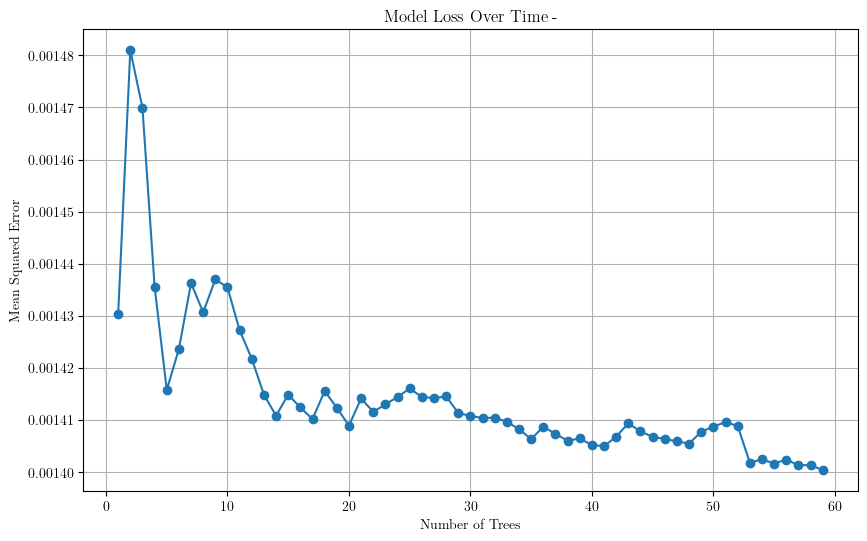

Calculating SHAP values: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4680/4680 [03:07<00:00, 25.00it/s]


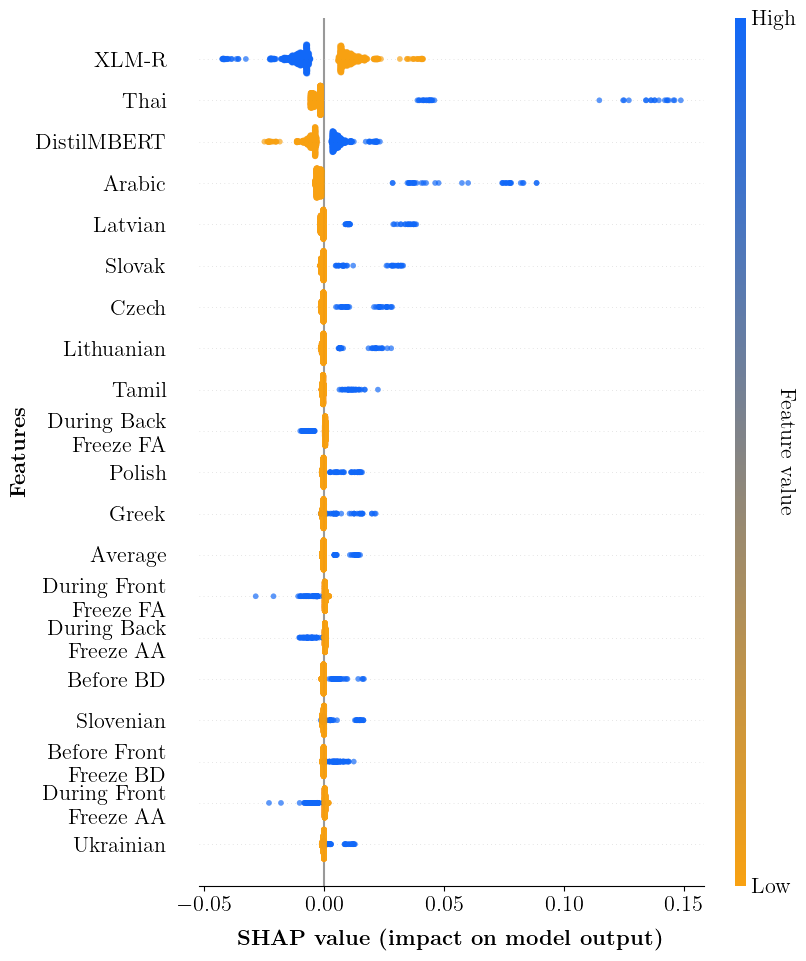

/tmp/ipykernel_234038/1556928709.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(new_labels)


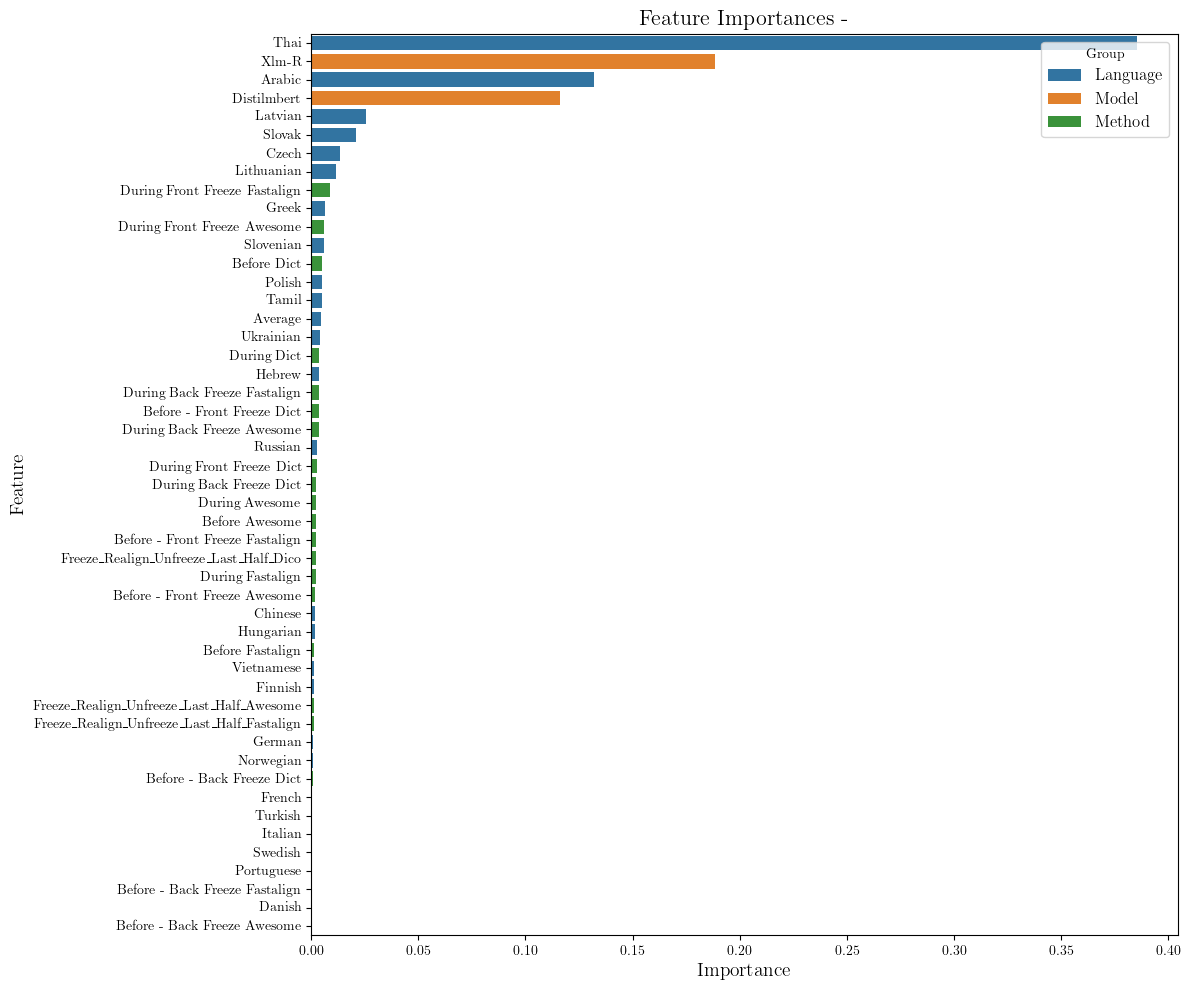

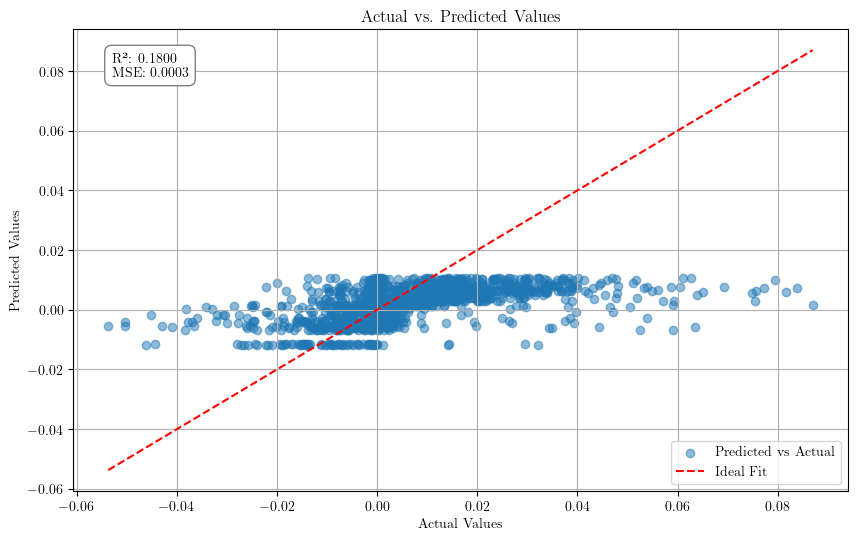

Feature Importances:
model_XLM-R                                           0.188392
model_distilMBERT                                     0.115926
method_Before - Back Freeze Awesome                   0.000292
method_Before - Back Freeze Dict                      0.000705
method_Before - Back Freeze FastAlign                 0.000382
method_Before - Front Freeze Awesome                  0.001892
method_Before - Front Freeze Dict                     0.003520
method_Before - Front Freeze FastAlign                0.002282
method_Before Awesome                                 0.002316
method_Before Dict                                    0.005176
method_Before FastAlign                               0.001518
method_During Awesome                                 0.002391
method_During Back Freeze Awesome                     0.003495
method_During Back Freeze Dict                        0.002442
method_During Back Freeze FastAlign                   0.003569
method_During Dict                

In [35]:
coefficients, encoded_columns = perform_regression(train_data, val_data, test_data, use_linear_regressor=False)

print("Feature Importances:")
print(coefficients)

/tmp/ipykernel_234038/1556928709.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(new_labels)


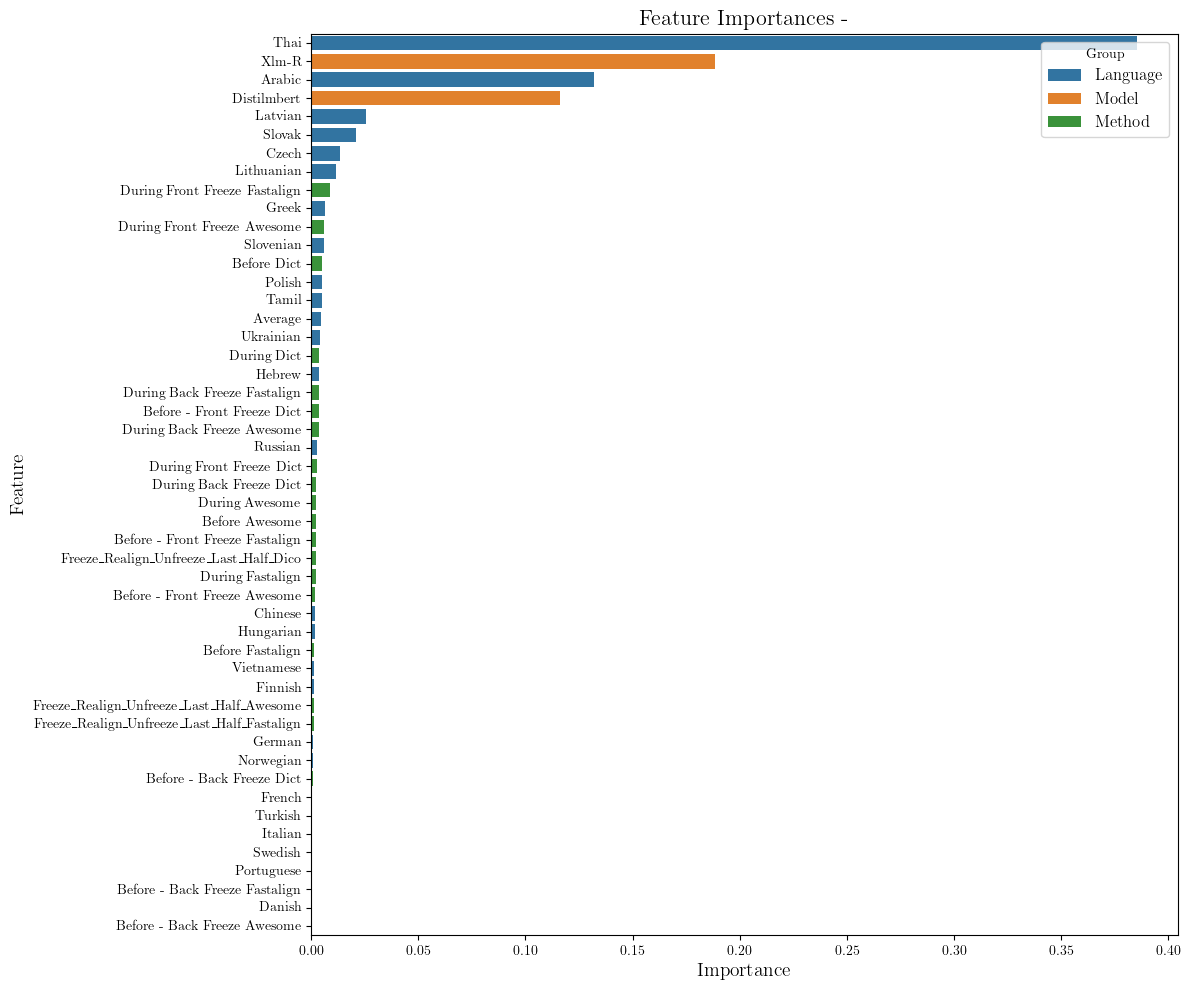

In [36]:
plot_feature_importances(coefficients, encoded_columns)

## Maps

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

language_families = {
    'Afrikaans': 'Germanic',
    'Arabic': 'Semitic',
    'Bulgarian': 'Slavic',
    'Catalan': 'Romance',
    'Chinese': 'Sino-Tibetan',
    'Czech': 'Slavic',
    'Danish': 'Germanic',
    'Finnish': 'Uralic',
    'French': 'Romance',
    'German': 'Germanic',
    'Greek': 'Hellenic',
    'Hebrew': 'Semitic',
    'Hindi': 'Indo-Aryan',
    'Hungarian': 'Uralic',
    'Italian': 'Romance',
    'Japanese': 'Japonic',
    'Korean': 'Koreanic',
    'Latvian': 'Baltic',
    'Lithuanian': 'Baltic',
    'Norwegian': 'Germanic',
    'Persian': 'Iranian',
    'Polish': 'Slavic',
    'Portuguese': 'Romance',
    'Romanian': 'Romance',
    'Russian': 'Slavic',
    'Slovak': 'Slavic',
    'Slovenian': 'Slavic',
    'Spanish': 'Romance',
    'Swedish': 'Germanic',
    'Tamil': 'Dravidian',
    'Thai': 'Kra-Dai',
    'Turkish': 'Turkic',
    'Ukrainian': 'Slavic',
    'Vietnamese': 'Austroasiatic'
}

# See https://aclanthology.org/2020.acl-main.560.pdf
joshi_classes = {
    'Afrikaans': 3,
    'Arabic': 5,
    'Bulgarian': 3,
    'Catalan': 4,
    'Chinese': 5,
    'Czech': 4,
    'Danish': 3,
    'Finnish': 4,
    'French': 5,
    'German': 5,
    'Greek': 3,
    'Hebrew': 3,
    'Hindi': 4,
    'Hungarian': 4,
    'Italian': 4,
    'Japanese': 5,
    'Korean': 4,
    'Latvian': 3,
    'Lithuanian': 3,
    'Norwegian': 1,
    'Persian': 4,
    'Polish': 4,
    'Portuguese': 4,
    'Romanian': 3,
    'Russian': 4,
    'Slovak': 3,
    'Slovenian': 3,
    'Spanish': 5,
    'Swedish': 4,
    'Tamil': 3,
    'Thai': 3,
    'Turkish': 4,
    'Ukrainian': 3,
    'Vietnamese': 4
}

# Convert token data to DataFrame
token_df = pd.DataFrame(list(xlmr_token_data.items()), columns=['language', 'tokens_millions'])

# Merge token data with xlmr_df_tokens
xlmr_df_tokens = combined_df[combined_df['model'] == 'XLM-R']
merged_df = xlmr_df_tokens.merge(token_df, on='language')

# Calculate the average delta accuracy for each language
average_delta_accuracy = merged_df.groupby('language')['delta_accuracy'].mean().reset_index()

# Merge average delta accuracy with token data
final_df = average_delta_accuracy.merge(token_df, on='language')
final_df["language_family"] = final_df["language"].map(language_families)
final_df["language_joshi_class"] = final_df["language"].map(joshi_classes)

final_df.sort_values(by="language_joshi_class", ascending=False)

,language,delta_accuracy,tokens_millions,language_family,language_joshi_class
1,Arabic,0.018009,2869.0,Semitic,5
4,Chinese,-0.005072,176.0,Sino-Tibetan,5
27,Spanish,-0.000345,9374.0,Romance,5
9,German,0.004920,10297.0,Germanic,5
8,French,0.002332,9780.0,Romance,5
15,Japanese,0.007120,530.0,Japonic,5
28,Swedish,0.000371,77.8,Germanic,4
7,Finnish,-0.004368,6730.0,Uralic,4
13,Hungarian,-0.004784,7807.0,Uralic,4
5,Czech,-0.001397,2498.0,Slavic,4


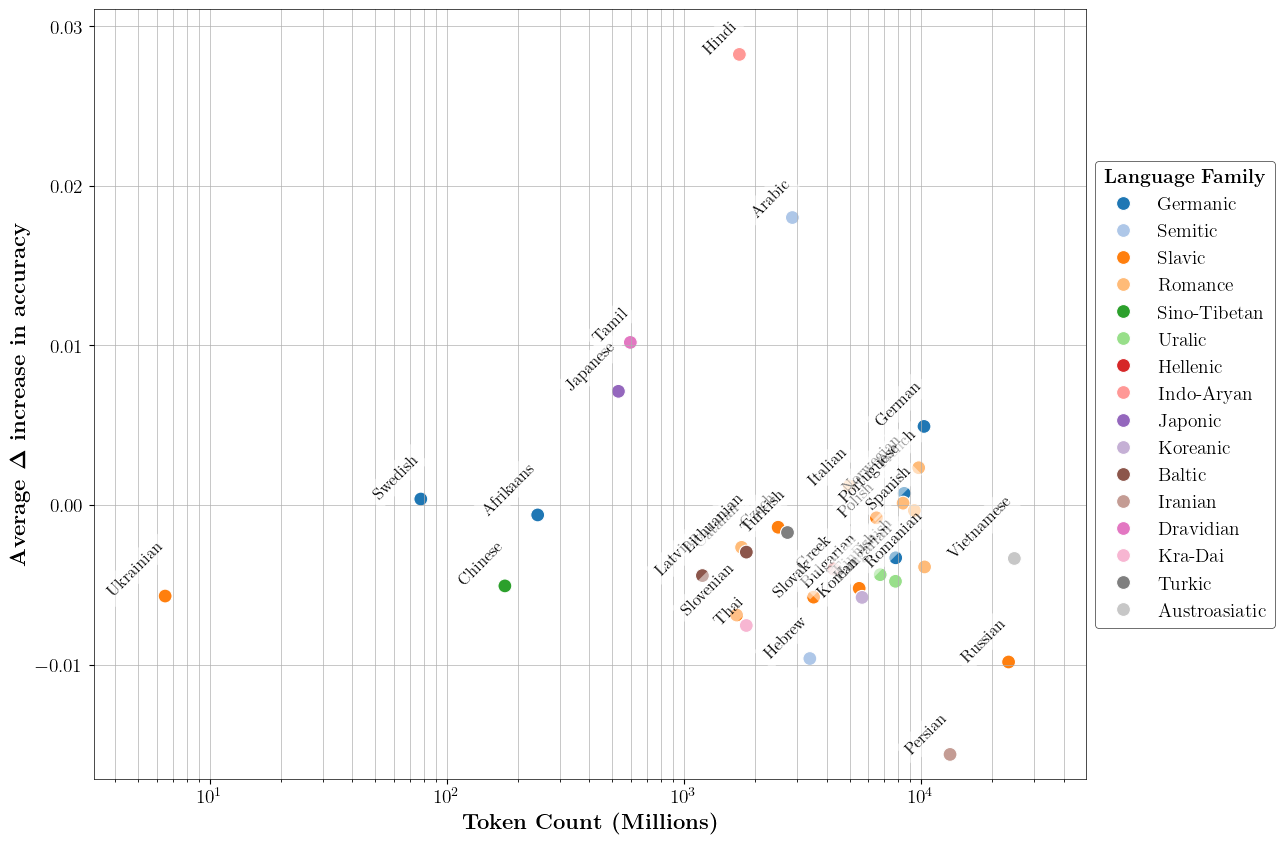

In [44]:
# Create a figure and axis object
fig, ax = plt.subplots(figsize=(16, 10))

# Plot the data
sns.scatterplot(
    data=final_df,
    x="tokens_millions",
    y="delta_accuracy",
    s=100,
    ax=ax,
    hue="language_family",
    palette="tab20",
)

# Set the y-axis limits to focus on the range of delta accuracy values
ax.set_ylim(-0.02, 0.03)

# Add annotations for each language with rotation and better placement
for i in range(final_df.shape[0]):
    ax.text(
        x=final_df.tokens_millions[i],
        y=final_df.delta_accuracy[i],
        s=final_df.language[i],
        fontdict=dict(color="black", size=12),
        rotation=45,
        horizontalalignment="right",
        bbox=dict(facecolor="white", alpha=0.5, edgecolor="none"),
    )

# ax.set_title(
#     r"\textbf{Average $\bm{\Delta}$ Accuracy vs. Token Count for XLM-R by Language}",
#     fontsize=16,
# )
ax.set_xlabel(r"\textbf{Token Count (Millions)}", fontsize=16)
ax.set_ylabel(r"\textbf{Average $\bm{\Delta}$ increase in accuracy}", fontsize=16)
ax.set_xscale("log")
ax.grid(True, which="both", linestyle="-", linewidth=0.5)

# Thicker border
for spine in ax.spines.values():
    spine.set_linewidth(0.5)
    spine.set_color("black") 
    
# Shrink the plot to make room for the legend
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put the legend outside the plot on the right side
legend = ax.legend(
    loc="center left",
    bbox_to_anchor=(1, 0.5),
    title=r"\textbf{Language Family}",
    fontsize=14,
    title_fontsize=14,
    edgecolor="black",
)

# Set the legend border color and thickness
legend_frame = legend.get_frame()
legend_frame.set_edgecolor('black') 
legend_frame.set_linewidth(0.5)  

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xlim(0.5 * final_df["tokens_millions"].min(), 2 * final_df["tokens_millions"].max())
plt.ylim(1.1 * final_df["delta_accuracy"].min(), 1.1 * final_df["delta_accuracy"].max())

plt.savefig("regression_plots/xlmr_pos_delta_vs_tokens_by_family.pdf", bbox_inches="tight")
plt.show()

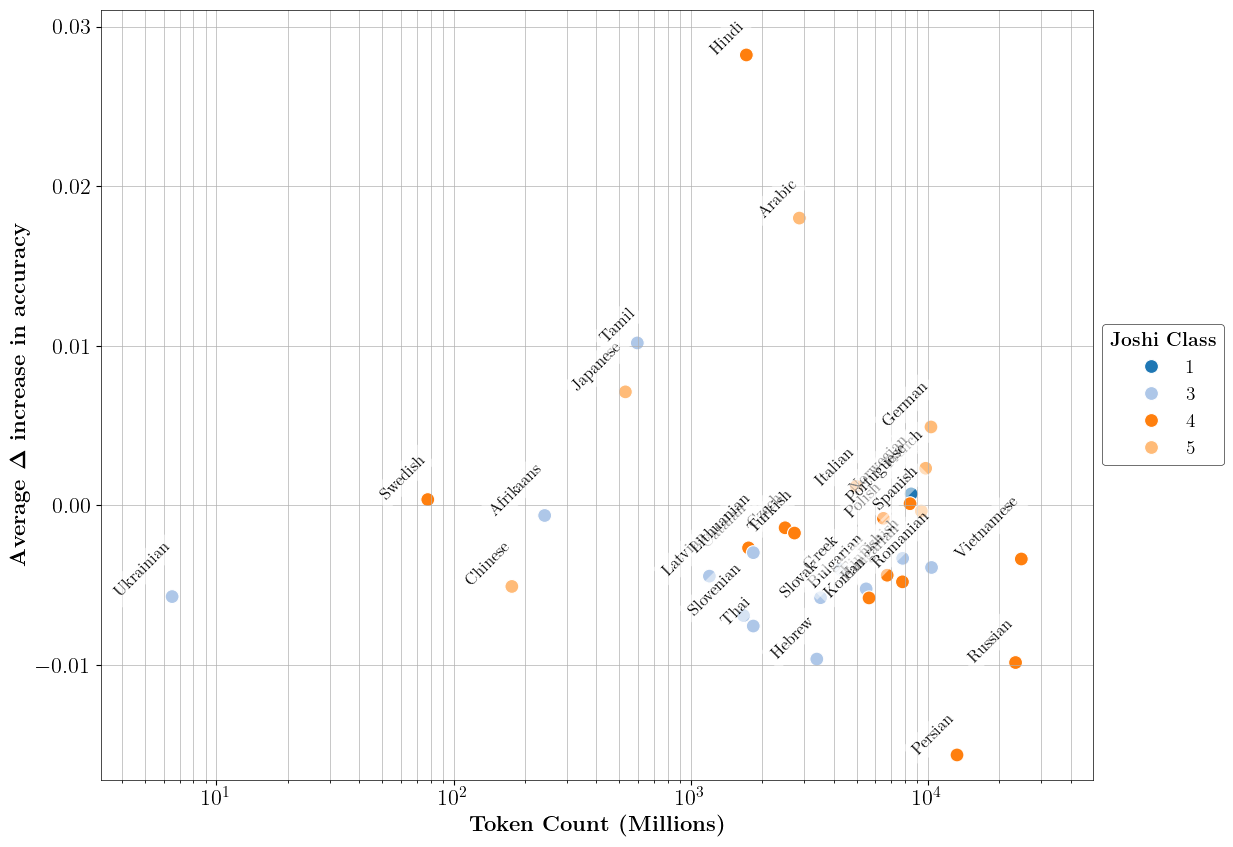

In [43]:
# Create a figure and axis object
fig, ax = plt.subplots(figsize=(16, 10))

# Plot the data
sns.scatterplot(
    data=final_df,
    x="tokens_millions",
    y="delta_accuracy",
    s=100,
    ax=ax,
    hue="language_joshi_class",
    palette="tab20",
)

# Set the y-axis limits to focus on the range of delta accuracy values
ax.set_ylim(-0.02, 0.03)

# Add annotations for each language with rotation and better placement
for i in range(final_df.shape[0]):
    ax.text(
        x=final_df.tokens_millions[i],
        y=final_df.delta_accuracy[i],
        s=final_df.language[i],
        fontdict=dict(color="black", size=12),
        rotation=45,
        horizontalalignment="right",
        bbox=dict(facecolor="white", alpha=0.5, edgecolor="none"),
    )

# ax.set_title(
#     r"\textbf{Average $\bm{\Delta}$ Accuracy vs. Token Count for XLM-R by Language}",
#     fontsize=16,
# )
ax.set_xlabel(r"\textbf{Token Count (Millions)}", fontsize=16)
ax.set_ylabel(r"\textbf{Average $\bm{\Delta}$ increase in accuracy}", fontsize=16)
ax.set_xscale("log")
ax.grid(True, which="both", linestyle="-", linewidth=0.5)

# Thicker border
for spine in ax.spines.values():
    spine.set_linewidth(0.5)
    spine.set_color("black") 

# Shrink the plot to make room for the legend
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put the legend outside the plot on the right side
legend = ax.legend(
    loc="center left",
    bbox_to_anchor=(1, 0.5),
    title=r"\textbf{Joshi Class}",
    fontsize=14,
    title_fontsize=14,
    edgecolor="black",
)

# Set the legend border color and thickness
legend_frame = legend.get_frame()
legend_frame.set_edgecolor('black') 
legend_frame.set_linewidth(0.5)  

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.xlim(0.5 * final_df["tokens_millions"].min(), 2 * final_df["tokens_millions"].max())
plt.ylim(1.1 * final_df["delta_accuracy"].min(), 1.1 * final_df["delta_accuracy"].max())

plt.savefig("regression_plots/xlmr_pos_delta_vs_tokens_by_joshi.pdf", bbox_inches="tight")
plt.show()

In [45]:
# import pandas as pd

# # Load and transpose the dataset
# uri_data = pd.read_csv('./Raw URIEL Language Data.csv').transpose()

# # Reset the index and set the first row as the header
# uri_data.reset_index(inplace=True)
# uri_data.columns = uri_data.iloc[0]
# uri_data = uri_data.drop(uri_data.index[0])

# # Clean up column names
# uri_data.columns = uri_data.columns.str.replace('\n', '', regex=True).str.replace('↓', '', regex=True).str.strip()

# # Drop unnecessary columns
# columns_to_drop = ['ISO 639-3 Code', 'Features']
# uri_data.drop(columns=[col for col in columns_to_drop if col in uri_data.columns], inplace=True)

# # Replace placeholder text with NaN in the 'S_SVO' column
# uri_data['S_SVO'] = uri_data['S_SVO'].replace('NO INFORMATION FOR ANY FEATURE', pd.NA)

# # Drop the 'S_SVO' column if it only contains NaN (i.e., if it is no longer useful)
# if uri_data['S_SVO'].isna().all():
#     uri_data.drop(columns=['S_SVO'], inplace=True)

# # Drop columns with any NaN values
# uri_data.dropna(axis=1, inplace=True)

# # Clean up the 'Families' column
# if 'Families' in uri_data.columns:
#     uri_data['Families'] = uri_data['Families'].str.replace(r'[\n\r]+', ', ', regex=True)
#     uri_data['Families'] = uri_data['Families'].str.replace('F_', '')
#     uri_data['Families'] = uri_data['Families'].str.replace(', ,', ', ')
#     # Keep only the first family listed
#     uri_data['Families'] = uri_data['Families'].apply(lambda x: x.split(',')[0] if pd.notna(x) else x)

# # Specifically, find the row for Norwegian and update its family
# norwegian_index = uri_data[uri_data['Languages'] == 'Norwegian'].index
# if not norwegian_index.empty:
#     uri_data.at[norwegian_index[0], 'Families'] = "Indo-European"


# # uri_data.to_csv('./cleaned_uri_data.csv')


In [46]:
# # Specify the columns containing geographic coordinates
# gc_columns = [col for col in uri_data.columns if col.startswith('GC_')]
# uri_data[gc_columns] = uri_data[gc_columns].apply(pd.to_numeric, errors='coerce')

# def extract_coordinates(column_name):
#     """Extract latitude and longitude from the column name."""
#     _, lat, lon = column_name.split('_')
#     return float(lat), float(lon)

# def find_closest_coordinates(uri_data, gc_columns):
#     closest_coordinates = {}
#     for i, row in uri_data.iterrows():
#         language = row['Languages']
#         closest_column = row[gc_columns].idxmin()  # Find the column with the minimum value
#         closest_coordinates[language] = closest_column  # Store the column name
#     return closest_coordinates

# def calculate_geographic_distances(language_of_interest, uri_data, closest_coordinates):
#     # Ensure the language of interest exists in the dataset
#     if language_of_interest not in closest_coordinates:
#         raise ValueError(f"Language '{language_of_interest}' not found in the dataset.")
    
#     # Extract the geographic coordinate column for the language of interest
#     target_coord_column = closest_coordinates[language_of_interest]
#     target_lat, target_lon = extract_coordinates(target_coord_column)
    
#     # Calculate the Euclidean distance from the target language to each other language
#     distance_results = []
#     for language, coord_column in closest_coordinates.items():
#         if language != language_of_interest:
#             lat, lon = extract_coordinates(coord_column)
#             distance = np.linalg.norm([target_lat - lat, target_lon - lon])  # Euclidean distance
#             distance_results.append({
#                 'language': language,
#                 'Distance': distance,
#                 'Nearest_Coordinate_Column': coord_column,
#                 'Latitude': lat,
#                 'Longitude': lon
#             })
    
#     # Convert the results to a DataFrame for easy viewing
#     distance_df = pd.DataFrame(distance_results)
#     return distance_df

# def find_nearest_neighbors(language_of_interest, uri_data, n_neighbors=5):
#     # Find the closest coordinates for each language
#     closest_coordinates = find_closest_coordinates(uri_data, gc_columns)
    
#     # Calculate geographic distances for the language of interest
#     distance_df = calculate_geographic_distances(language_of_interest, uri_data, closest_coordinates)
    
#     # Sort the distances and get the top N nearest neighbors
#     nearest_neighbors_df = distance_df.sort_values(by='Distance').head(n_neighbors)
    
#     return nearest_neighbors_df

In [47]:
# # Find the closest coordinates for each language
# closest_coordinates = find_closest_coordinates(uri_data, gc_columns)

# distances = calculate_geographic_distances('English', uri_data, closest_coordinates)

# distances.rename(columns={'Language': 'language'}, inplace=True)
# distances

In [48]:
# # Merge the distances DataFrame with the combined DataFrame on the 'language' column
# combined_df_with_distances = combined_df.merge(distances, on='language', how='left')

# # Add the Families column from uri_data
# uri_data_subset = uri_data[['Languages', 'Families']]
# uri_data_subset.rename(columns={'Languages': 'language'}, inplace=True)

# # Merge Families into combined_df
# combined_df_with_distances = combined_df_with_distances.merge(uri_data_subset, on='language', how='left')

# # Drop duplicate Distance columns if present
# if 'Distance_x' in combined_df_with_distances.columns and 'Distance_y' in combined_df_with_distances.columns:
#     combined_df_with_distances.drop(columns=['Distance_x'], inplace=True)
#     combined_df_with_distances.rename(columns={'Distance_y': 'Distance'}, inplace=True)

# # Drop duplicate Families columns if present
# if 'Families_x' in combined_df_with_distances.columns and 'Families_y' in combined_df_with_distances.columns:
#     combined_df_with_distances.drop(columns=['Families_x'], inplace=True)
#     combined_df_with_distances.rename(columns={'Families_y': 'Families'}, inplace=True)

# # Drop rows where 'Distance' is NaN
# combined_df_with_distances.dropna(subset=['Distance'], inplace=True)

# # Drop rows where 'language' is 'Average'
# combined_df_with_distances = combined_df_with_distances[combined_df_with_distances['language'] != 'Average']

# # Drop unnecessary columns
# columns_to_drop = ['Nearest_Coordinate_Column', 'Nearest_Coordinate_Value', 'Latitude', 'Longitude']
# combined_df_with_distances.drop(columns=[col for col in columns_to_drop if col in combined_df_with_distances.columns], inplace=True)

# combined_df_with_distances.head()  # Display the head of the combined DataFrame to verify the changes


In [49]:
# combined_df_with_distances

## Using distance in regression

In [50]:
combined_df_with_distances = add_language_distances_to_df(combined_df)

Error: Average is not in the language mapping.


In [51]:
combined_df_with_distances = combined_df_with_distances[~combined_df_with_distances.isna().any(axis=1)]

# combined_df_with_distances = combined_df

In [52]:
train_dist_data, val_dist_data, test_dist_data = split_train_val_test(combined_df_with_distances, use_standard_split=True)

In [53]:
train_dist_data

,model,method,language,delta_accuracy,syntactic,geographic,phonological,genetic,inventory,featural
0,distilMBERT,freeze_realign_unfreeze_last_half_fastalign,Hungarian,0.027850,0.60,0.1,0.3433,1.0000,0.4581,0.5
1,XLM-R,During Front Freeze Awesome,Bulgarian,0.001972,0.48,0.1,0.2804,0.8571,0.5210,0.5
2,XLM-R,During Front Freeze Dict,Portuguese,-0.000920,0.47,0.1,0.5687,0.9000,0.4235,0.5
3,XLM-R,During Back Freeze FastAlign,Italian,-0.002689,0.51,0.1,0.5687,0.9000,0.5064,0.5
4,XLM-R,Before - Front Freeze FastAlign,Finnish,0.001138,0.53,0.1,0.2736,1.0000,0.4694,0.5
...,...,...,...,...,...,...,...,...,...,...
4404,distilMBERT,During Front Freeze Awesome,Vietnamese,0.004015,0.57,0.5,0.4270,1.0000,0.4550,0.5
4405,distilMBERT,Before - Front Freeze Awesome,Finnish,0.029261,0.53,0.1,0.2736,1.0000,0.4694,0.5
4406,distilMBERT,Before - Front Freeze FastAlign,German,0.007214,0.42,0.1,0.3277,0.4286,0.4364,0.4
4407,distilMBERT,Before - Front Freeze Dict,Lithuanian,0.067754,0.68,0.1,0.3498,0.9000,0.4694,0.5


In [54]:
val_dist_data

,model,method,language,delta_accuracy,syntactic,geographic,phonological,genetic,inventory,featural
0,distilMBERT,freeze_realign_unfreeze_last_half_fastalign,Hindi,0.036579,0.59,0.4,0.3433,0.9000,0.4684,0.5
1,distilMBERT,During Back Freeze Awesome,Slovak,0.055752,0.57,0.1,0.5687,0.9000,0.5983,0.6
2,XLM-R,During Back Freeze Dict,Turkish,-0.002438,0.70,0.1,0.3433,1.0000,0.5183,0.6
3,XLM-R,Before - Front Freeze Dict,Romanian,0.002757,0.53,0.1,0.3498,0.9000,0.4997,0.5
4,distilMBERT,Before - Front Freeze Awesome,Czech,0.059295,0.66,0.1,0.5687,0.9000,0.5368,0.6
...,...,...,...,...,...,...,...,...,...,...
625,distilMBERT,Before Dict,Turkish,0.018691,0.70,0.1,0.3433,1.0000,0.5183,0.6
626,XLM-R,During FastAlign,Catalan,0.001948,0.53,0.1,0.2804,0.9000,0.4581,0.5
627,distilMBERT,During Awesome,Czech,0.056740,0.66,0.1,0.5687,0.9000,0.5368,0.6
628,distilMBERT,During Awesome,Bulgarian,0.020542,0.48,0.1,0.2804,0.8571,0.5210,0.5


In [55]:
test_dist_data

,model,method,language,delta_accuracy,syntactic,geographic,phonological,genetic,inventory,featural
0,distilMBERT,During Front Freeze Awesome,English,0.000747,0.00,0.0,0.0002,0.0000,0.0000,0.0
1,XLM-R,During Dict,Catalan,-0.003775,0.53,0.1,0.2804,0.9000,0.4581,0.5
2,distilMBERT,During Dict,Persian,0.017848,0.57,1.0,0.5687,1.0000,0.5983,0.6
3,XLM-R,During Front Freeze Dict,Chinese,0.002248,0.55,0.4,0.3900,1.0000,0.5926,0.6
4,distilMBERT,Before - Front Freeze Awesome,Afrikaans,0.011227,0.63,0.4,0.5687,0.6000,0.5144,0.6
...,...,...,...,...,...,...,...,...,...,...
1256,distilMBERT,During Front Freeze FastAlign,Norwegian,0.000534,0.52,0.1,0.4477,1.0000,0.4769,0.5
1257,XLM-R,Before FastAlign,Danish,-0.003791,0.50,0.0,0.5687,0.7000,0.5983,0.7
1258,distilMBERT,freeze_realign_unfreeze_last_half_awesome,Japanese,-0.004910,0.66,0.5,0.5032,1.0000,0.5472,0.6
1259,XLM-R,Before - Back Freeze Awesome,Korean,-0.017813,0.62,0.4,0.4638,1.0000,0.4866,0.5


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:00<00:00, 63.37it/s]



Final Test MSE for  (Random Forest): 0.00022517763892724855


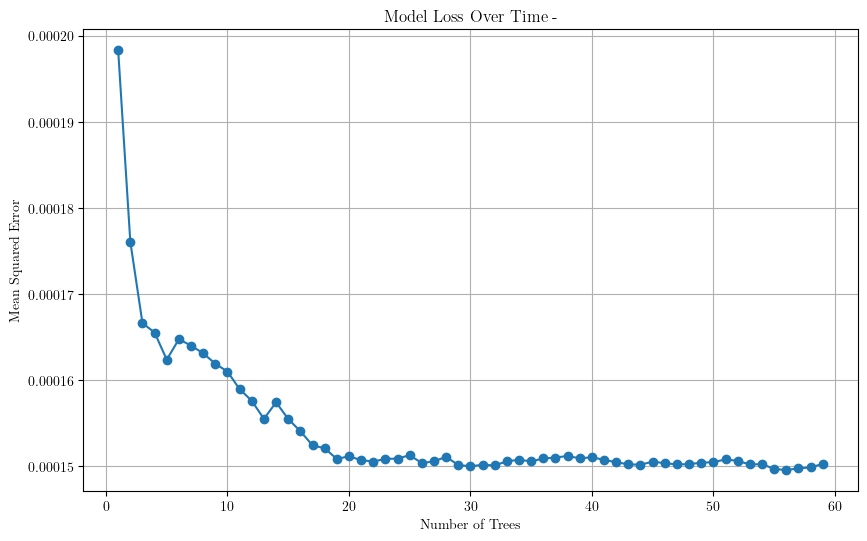

Calculating SHAP values: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4409/4409 [02:37<00:00, 27.99it/s]


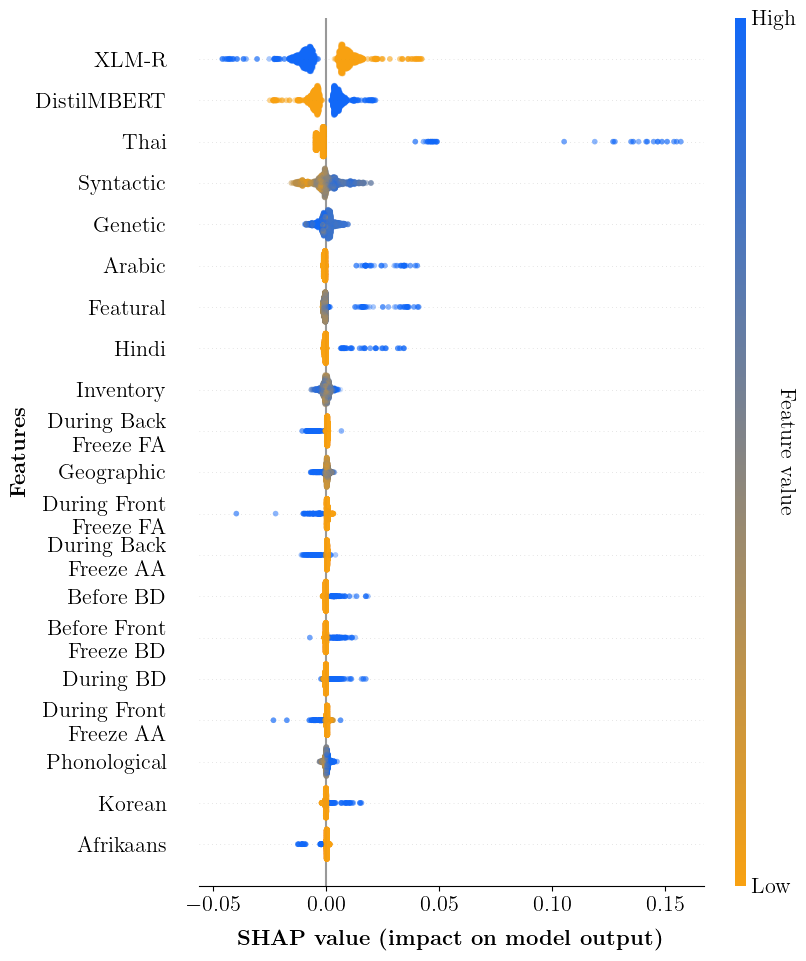

/tmp/ipykernel_234038/1556928709.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(new_labels)


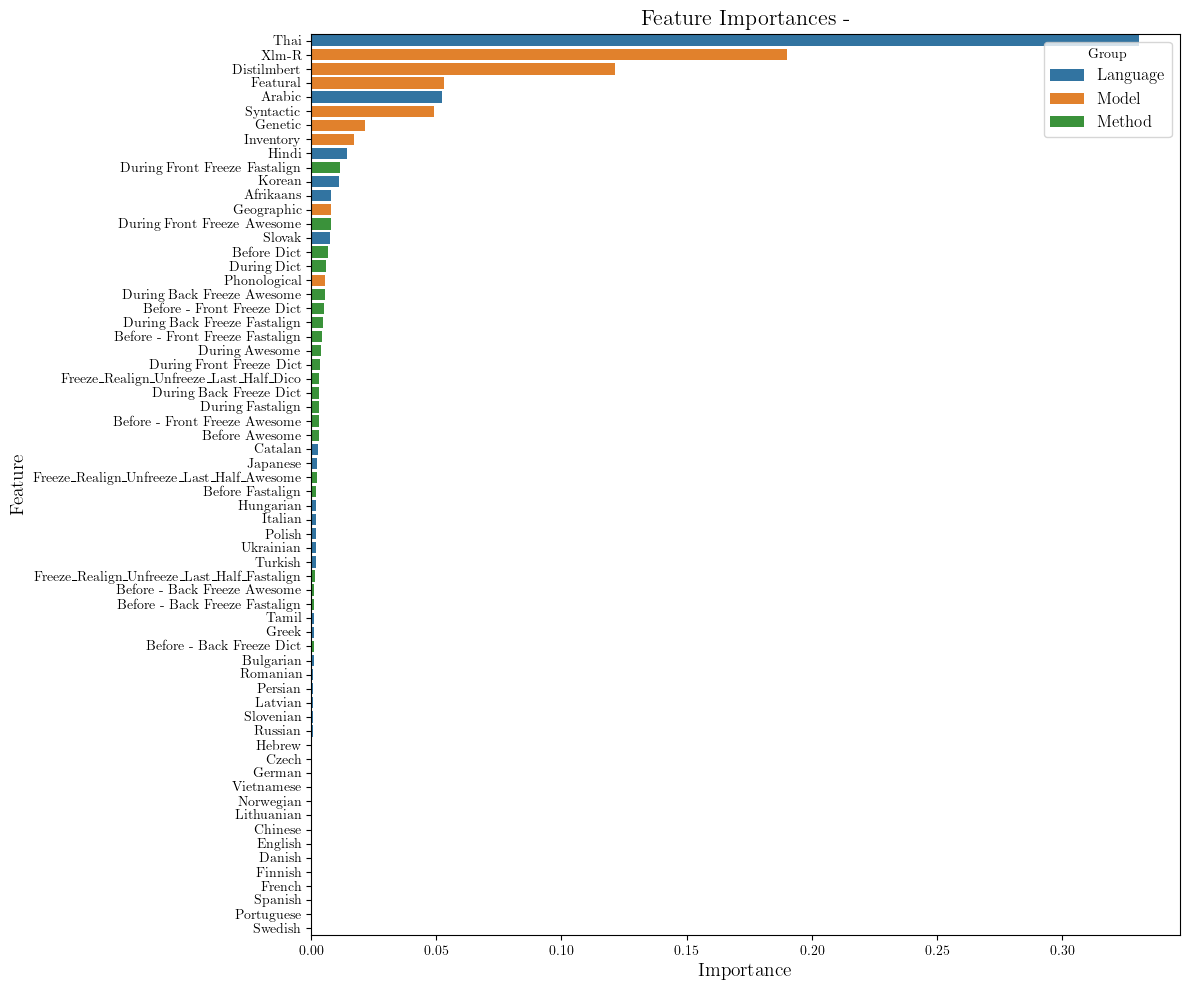

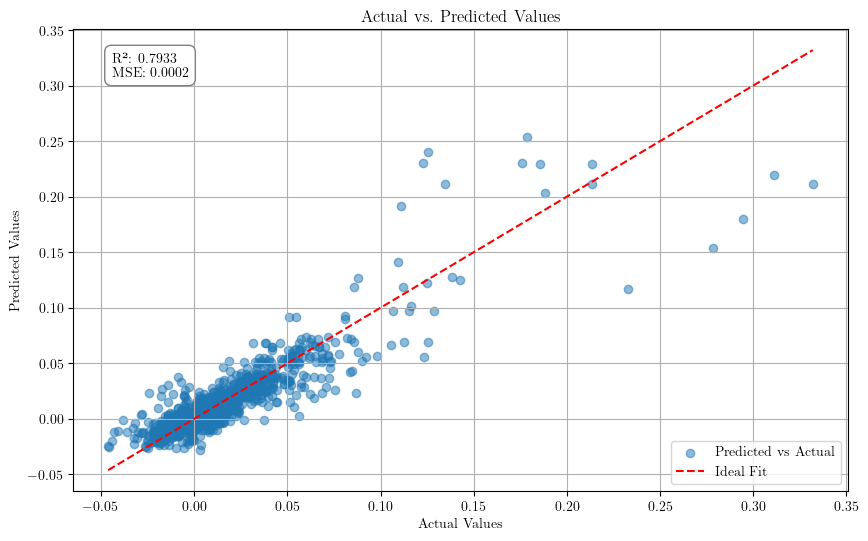

Feature Importances:
syntactic              0.049016
geographic             0.007871
phonological           0.005681
genetic                0.021450
inventory              0.016963
                         ...   
language_Tamil         0.001199
language_Thai          0.330519
language_Turkish       0.001844
language_Ukrainian     0.001911
language_Vietnamese    0.000302
Length: 64, dtype: float64


In [56]:
dist_coefficients, dist_encoded_columns = perform_regression(train_dist_data, val_dist_data, test_dist_data)

print("Feature Importances:")
print(dist_coefficients)

In [57]:
dist_encoded_columns

Index(['syntactic', 'geographic', 'phonological', 'genetic', 'inventory',
       'featural', 'model_XLM-R', 'model_distilMBERT',
       'method_Before - Back Freeze Awesome',
       'method_Before - Back Freeze Dict',
       'method_Before - Back Freeze FastAlign',
       'method_Before - Front Freeze Awesome',
       'method_Before - Front Freeze Dict',
       'method_Before - Front Freeze FastAlign', 'method_Before Awesome',
       'method_Before Dict', 'method_Before FastAlign',
       'method_During Awesome', 'method_During Back Freeze Awesome',
       'method_During Back Freeze Dict', 'method_During Back Freeze FastAlign',
       'method_During Dict', 'method_During FastAlign',
       'method_During Front Freeze Awesome', 'method_During Front Freeze Dict',
       'method_During Front Freeze FastAlign',
       'method_freeze_realign_unfreeze_last_half_awesome',
       'method_freeze_realign_unfreeze_last_half_dico',
       'method_freeze_realign_unfreeze_last_half_fastalign',
     

/tmp/ipykernel_234038/1556928709.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(new_labels)


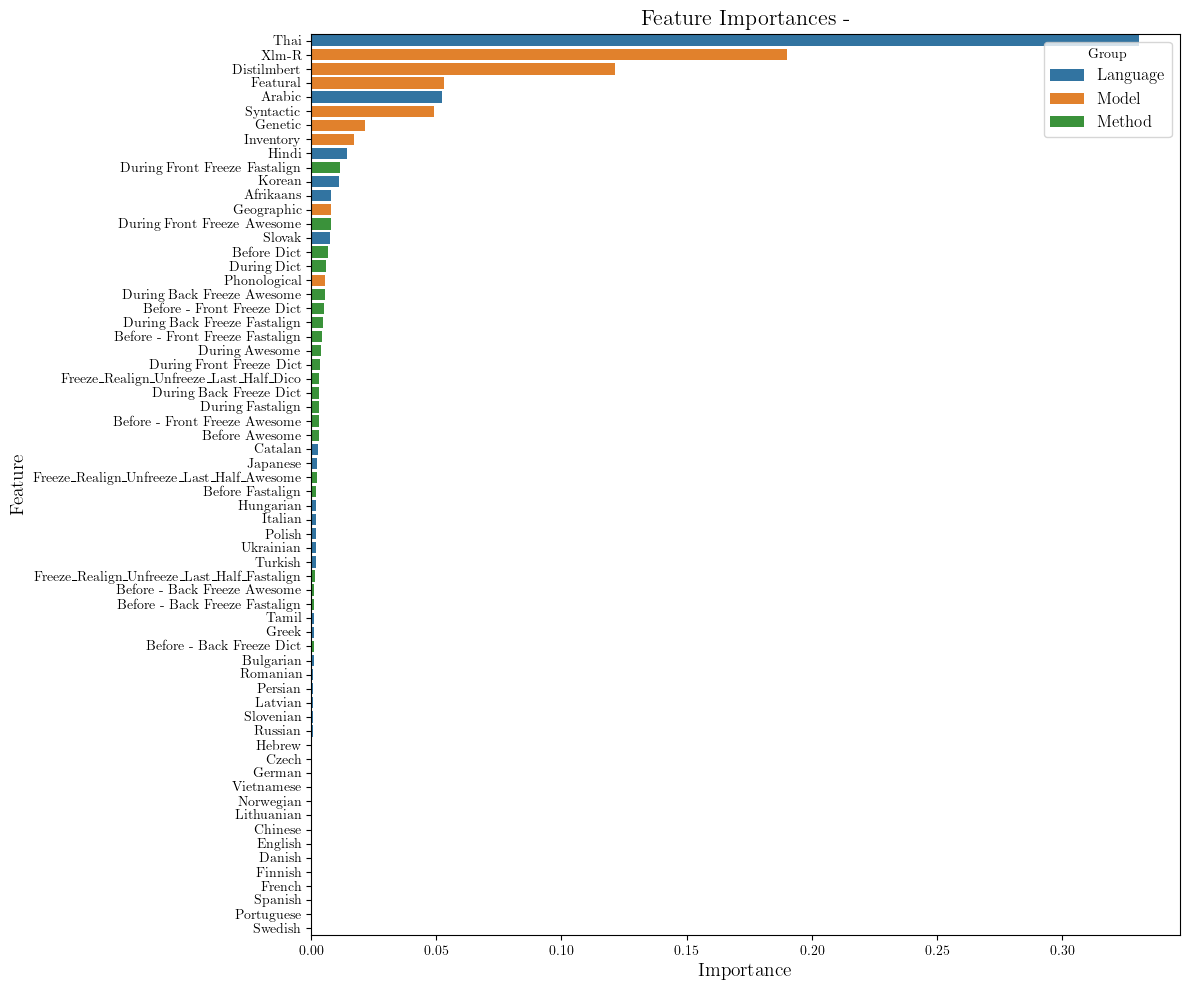

In [58]:
plot_feature_importances(dist_coefficients, dist_encoded_columns, group_by_distance=True)

In [59]:
def flag_freeze_methods(df, method_col='method'):
    df['method_type'] = df[method_col].apply(lambda x: 'freeze' if 'freeze' in x.lower() else 'vanilla')
    return df

In [60]:
combined_df_with_flags = flag_freeze_methods(combined_df_with_distances)
combined_df_with_flags = combined_df_with_flags[~combined_df_with_flags.isna().any(axis=1)]

/tmp/ipykernel_234038/328518364.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['method_type'] = df[method_col].apply(lambda x: 'freeze' if 'freeze' in x.lower() else 'vanilla')


In [61]:
combined_df_with_flags

,model,method,language,seed,accuracy,delta_accuracy,syntactic,geographic,phonological,genetic,inventory,featural,method_type
180,XLM-R,Before FastAlign,English,17,0.968070,0.001180,0.00,0.0,0.0002,0.0000,0.0000,0.0,vanilla
182,XLM-R,Before FastAlign,Afrikaans,17,0.885544,0.002683,0.63,0.4,0.5687,0.6000,0.5144,0.6,vanilla
183,XLM-R,Before FastAlign,Arabic,17,0.667102,0.044768,0.67,0.2,0.5687,1.0000,0.5983,0.8,vanilla
184,XLM-R,Before FastAlign,Bulgarian,17,0.891694,0.004515,0.48,0.1,0.2804,0.8571,0.5210,0.5,vanilla
185,XLM-R,Before FastAlign,Catalan,17,0.894724,0.000534,0.53,0.1,0.2804,0.9000,0.4581,0.5,vanilla
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6835,distilMBERT,During Back Freeze Awesome,Vietnamese,66,0.569218,-0.010874,0.57,0.5,0.4270,1.0000,0.4550,0.5,freeze
6836,distilMBERT,During Back Freeze Dict,Vietnamese,66,0.586951,0.006859,0.57,0.5,0.4270,1.0000,0.4550,0.5,freeze
6837,distilMBERT,freeze_realign_unfreeze_last_half_fastalign,Vietnamese,66,0.570724,-0.009368,0.57,0.5,0.4270,1.0000,0.4550,0.5,freeze
6838,distilMBERT,freeze_realign_unfreeze_last_half_awesome,Vietnamese,66,0.576746,-0.003346,0.57,0.5,0.4270,1.0000,0.4550,0.5,freeze


In [62]:
def run_regression_and_plot(df, description, save_path=None):
    train_data, val_data, test_data = split_train_val_test(df, use_standard_split=True)
    train_data = train_data.drop(columns=['method_type'])
    val_data = val_data.drop(columns=['method_type'])
    test_data = test_data.drop(columns=['method_type'])
    
    print(description)
    print()
    
    coefficients, encoded_columns = perform_regression(train_data, val_data, test_data, title=description, save_path=save_path)
    plot_feature_importances(coefficients, encoded_columns, group_by_distance=True, title=description)

### Regression by model and strategy

In [57]:
# # Aggregate
# run_regression_and_plot(combined_df_with_flags, "Using all data")

# # Freeze methods only
# freeze_df = combined_df_with_flags[combined_df_with_flags['method_type'] == 'freeze']
# run_regression_and_plot(freeze_df, "Using freeze methods only")

# # Vanilla methods only
# vanilla_df = combined_df_with_flags[combined_df_with_flags['method_type'] == 'vanilla']
# run_regression_and_plot(vanilla_df, "Using vanilla methods only")

# # XLM-R only
# xlmr_df = combined_df_with_flags[combined_df_with_flags['model'] == 'XLM-R']
# run_regression_and_plot(xlmr_df, "Using XLM-R only")

# # XLM-R freeze methods only
# xlmr_freeze_df = xlmr_df[xlmr_df['method_type'] == 'freeze']
# run_regression_and_plot(xlmr_freeze_df, "Using XLM-R freeze methods only")

# # XLM-R vanilla methods only
# xlmr_vanilla_df = xlmr_df[xlmr_df['method_type'] == 'vanilla']
# run_regression_and_plot(xlmr_vanilla_df, "Using XLM-R vanilla methods only")

# # distilMBERT only
# distilbert_df = combined_df_with_flags[combined_df_with_flags['model'] == 'distilMBERT']
# run_regression_and_plot(distilbert_df, "Using distilMBERT only")

# # distilMBERT freeze methods only
# distilbert_freeze_df = distilbert_df[distilbert_df['method_type'] == 'freeze']
# run_regression_and_plot(distilbert_freeze_df, "Using distilMBERT freeze methods only")

# # distilMBERT vanilla methods only
# distilbert_vanilla_df = distilbert_df[distilbert_df['method_type'] == 'vanilla']
# run_regression_and_plot(distilbert_vanilla_df, "Using distilMBERT vanilla methods only")

Using distilMBERT only



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:00<00:00, 104.28it/s]



Final Test MSE for Using distilMBERT only (Random Forest): 0.0003394435813092553


Calculating SHAP values: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 2204/2204 [00:28<00:00, 78.69it/s]


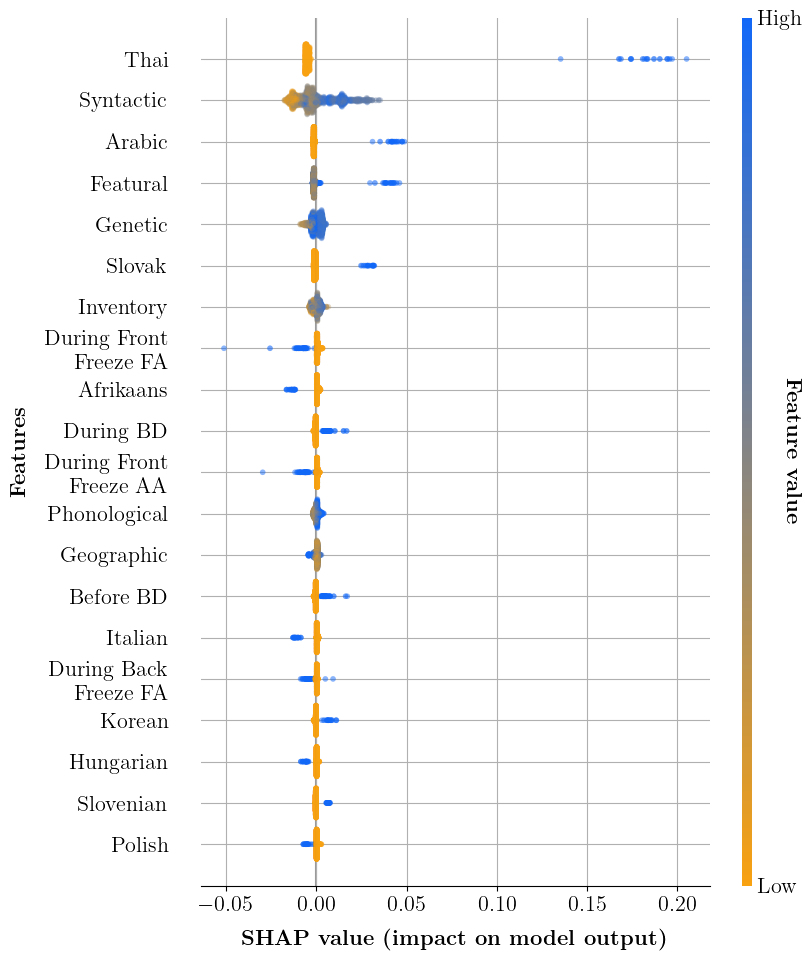

/tmp/ipykernel_234038/1556928709.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(new_labels)


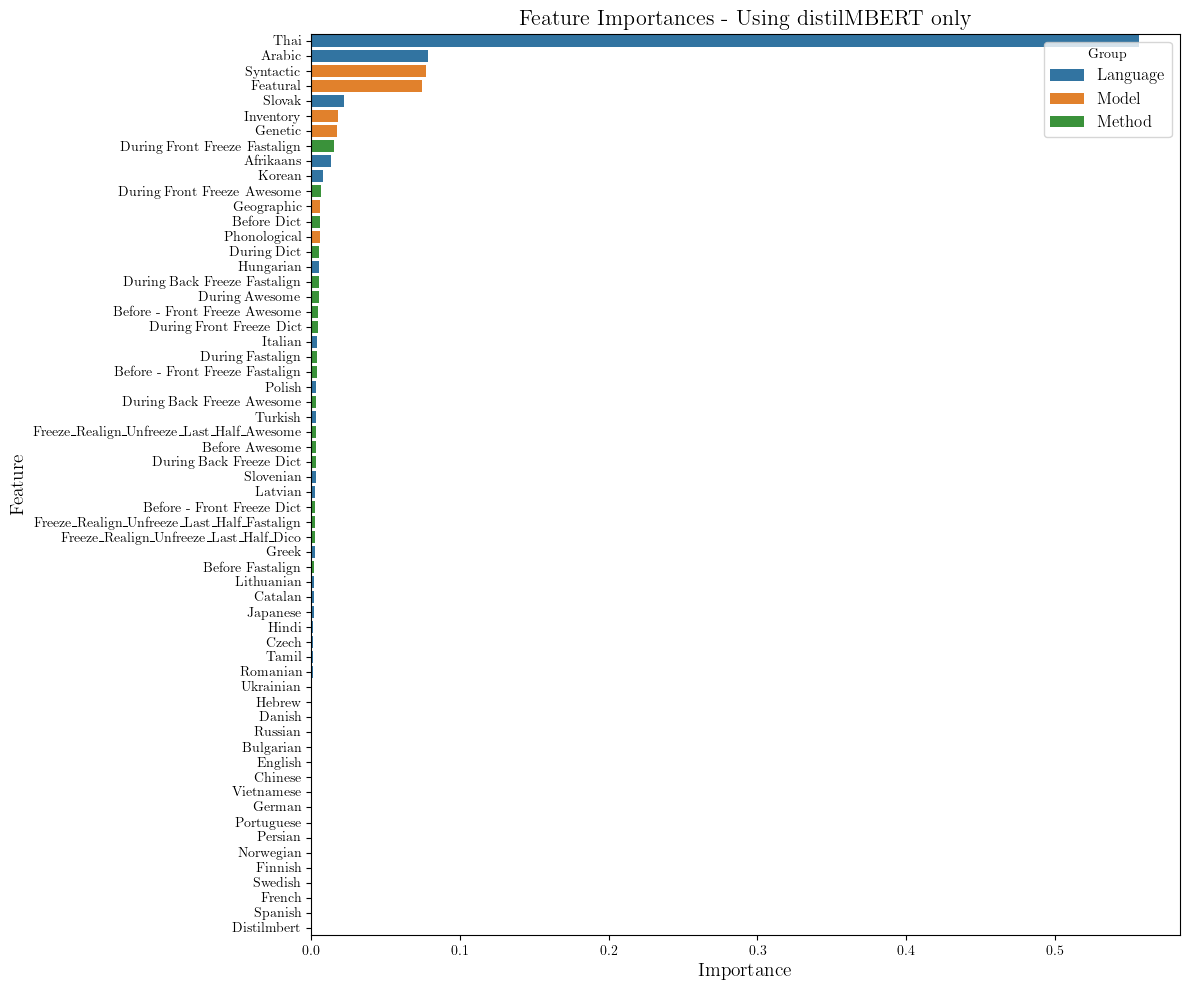

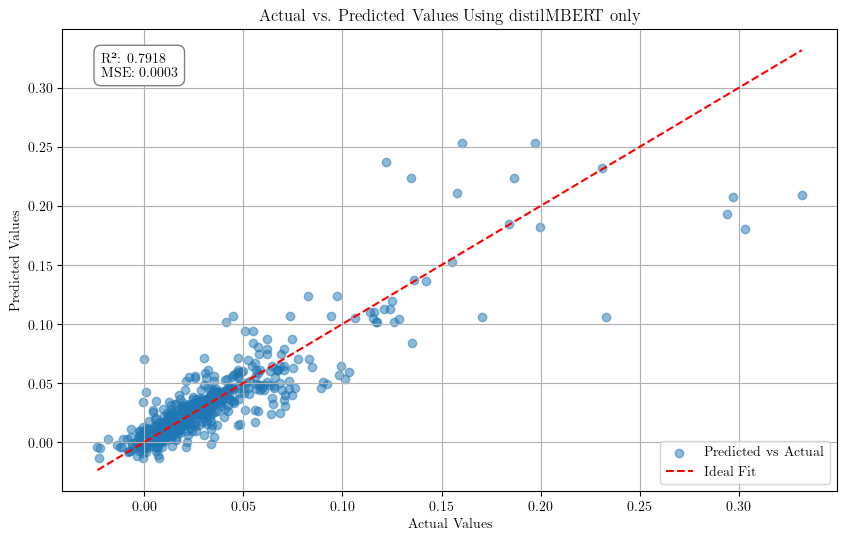

/tmp/ipykernel_234038/1556928709.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(new_labels)


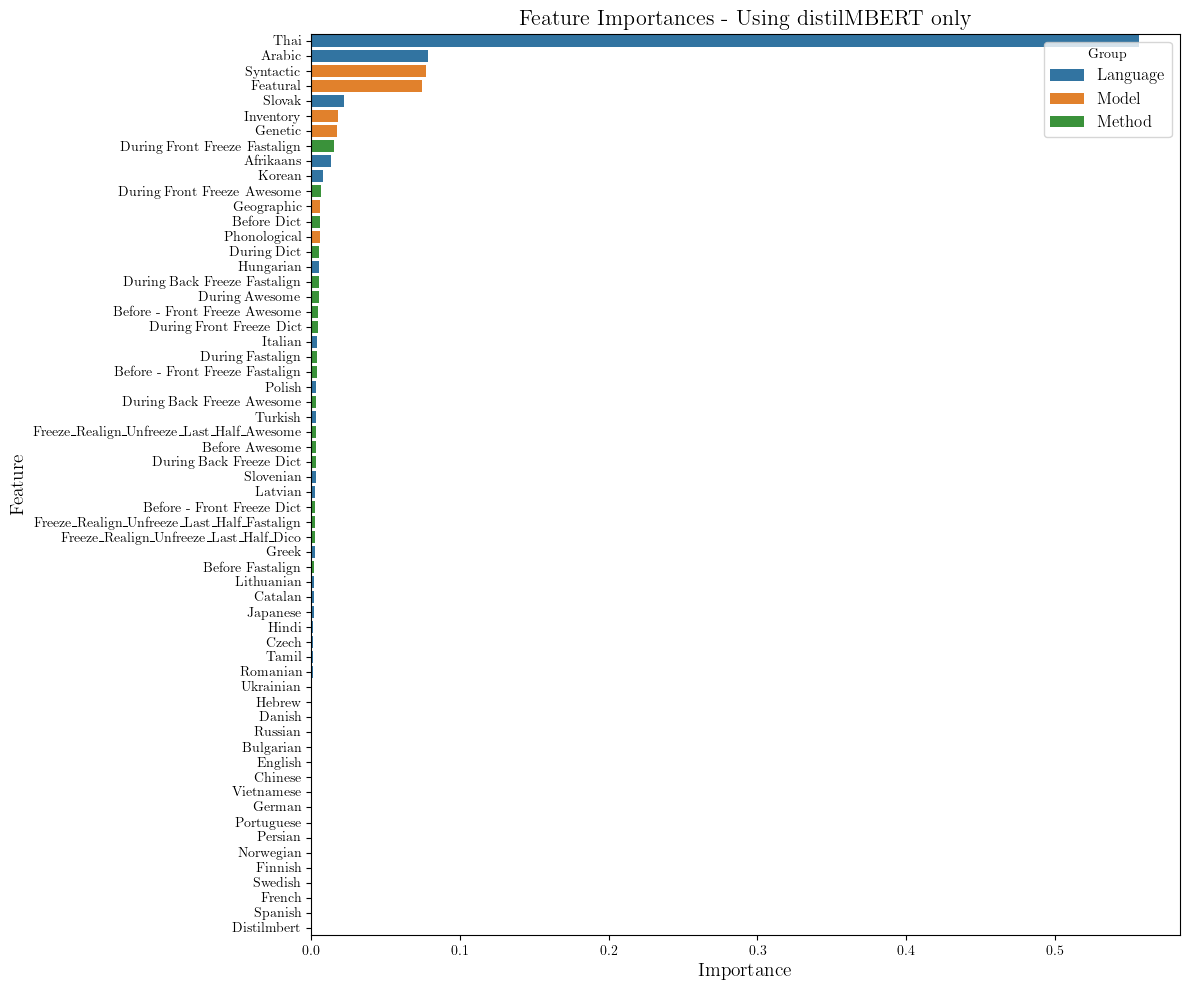

In [69]:
# distilMBERT only, tbis is the one in the paper
distilbert_df = combined_df_with_flags[combined_df_with_flags['model'] == 'distilMBERT']
run_regression_and_plot(distilbert_df, "Using distilMBERT only", save_path="regression_plots/distilmbert_pos/aggregate/")

## Thai analysis

In [70]:
# Filter for distilMBERT model
distilbert_df = combined_df_with_flags[combined_df_with_flags['model'] == 'distilMBERT']

# Filter for unique combinations of language and distance features
distance_features = ['syntactic', 'geographic', 'phonological', 'genetic', 'inventory', 'featural']
distance_df = distilbert_df[['language'] + distance_features].drop_duplicates()

# Drop the existing distance features
distance_df.drop(distance_features, axis=1, inplace=True)

# Add the distances back in, calculating the distance of all languages to Thai
distance_df = add_language_distances_to_df(target_lang='tha', lang_col='language', df=distance_df)

# Extract Thai's distance features
thai_distances = distance_df[distance_df['language'] == 'Thai'][distance_features].values

# Calculate Euclidean distances from Thai to all other languages
distances = euclidean_distances(thai_distances, distance_df[distance_features].values).flatten()

# Add the distances to the dataframe
distance_df['distance_to_thai'] = distances

# Sort the dataframe by the calculated distances
sorted_distance_df = distance_df.sort_values(by='distance_to_thai')

# Find the most similar languages to Thai (including Thai itself for reference)
similar_languages = sorted_distance_df
similar_language_names = similar_languages['language'].tolist()

# Filter the original dataframe for these languages to get their Delta accuracy
delta_accuracy_df = distilbert_df[distilbert_df['language'].isin(similar_language_names)]
average_delta_accuracy = delta_accuracy_df.groupby('language')['delta_accuracy'].mean().reset_index()

# Ensure the average_delta_accuracy dataframe maintains the same order
average_delta_accuracy['distance_to_thai'] = average_delta_accuracy['language'].map(
    similar_languages.set_index('language')['distance_to_thai']
)
average_delta_accuracy = average_delta_accuracy.sort_values(by='distance_to_thai')
average_delta_accuracy

,language,delta_accuracy,distance_to_thai
31,Thai,0.204766,0.000000
34,Vietnamese,0.000720,1.281838
8,Finnish,0.016478,1.451187
7,English,-0.000546,1.462026
22,Polish,0.031767,1.491073
3,Catalan,0.012726,1.492909
2,Bulgarian,0.020165,1.495727
24,Romanian,0.029530,1.498524
14,Hungarian,0.018056,1.500839
20,Norwegian,0.012945,1.501272


### Distance vs accuracy

In [96]:
data = {
    # "language": [
    #     "Thai", "Vietnamese", "Finnish", "English", "Polish", "Catalan", "Bulgarian", "Romanian", 
    #     "Hungarian", "Norwegian", "Chinese", "Hindi", "Korean", "Russian", "French", "Portuguese", 
    #     "Hebrew", "German", "Swedish", "Slovenian", "Japanese", "Italian", "Greek", "Ukrainian", 
    #     "Spanish", "Turkish", "Lithuanian", "Slovak", "Afrikaans", "Tamil", "Czech", "Arabic", 
    #     "Latvian", "Danish", "Persian"
    # ],
    "language": [
        "th", "vi", "fi", "en", "pl", "ca", "bg", "ro", "hu", "no", "zh",
        "hi", "ko", "ru", "fr", "pt", "he", "de", "sv", "sl", "ja", "it",
        "el", "uk", "es", "tr", "lt", "sk", "af", "ta", "cs", "ar", "lv",
        "da", "fa",
    ],
    "delta_accuracy": [
        0.204766, 0.000720, 0.016478, -0.000546, 0.031767, 0.012726, 0.020165, 0.029530, 
        0.018056, 0.012945, 0.017340, 0.054232, 0.056096, 0.021109, 0.008443, 0.005536, 
        0.023836, 0.007585, 0.007669, 0.035155, 0.032754, 0.004127, 0.035885, 0.028024, 
        0.009829, 0.005311, 0.045601, 0.057388, 0.004635, 0.024663, 0.048692, 0.116583, 
        0.063740, 0.002638, 0.000413
    ],
    "distance_to_thai": [
        0.000000, 1.281838, 1.451187, 1.462026, 1.491073, 1.492909, 1.495727, 1.498524, 
        1.500839, 1.501272, 1.506661, 1.514432, 1.515316, 1.529066, 1.536994, 1.538458, 
        1.545094, 1.552377, 1.561904, 1.565794, 1.566512, 1.567126, 1.578458, 1.580537, 
        1.599236, 1.599465, 1.602078, 1.626689, 1.630471, 1.697329, 1.701526, 1.709274, 
        1.712350, 1.733585, 1.867114
    ]
}

# Create DataFrame without an index
average_delta_accuracy = pd.DataFrame(data)
average_delta_accuracy = average_delta_accuracy.drop(index=[0]) # drop Thai to make the plots
average_delta_accuracy

,language,delta_accuracy,distance_to_thai
0,th,0.204766,0.000000
1,vi,0.000720,1.281838
2,fi,0.016478,1.451187
3,en,-0.000546,1.462026
4,pl,0.031767,1.491073
5,ca,0.012726,1.492909
6,bg,0.020165,1.495727
7,ro,0.029530,1.498524
8,hu,0.018056,1.500839
9,no,0.012945,1.501272


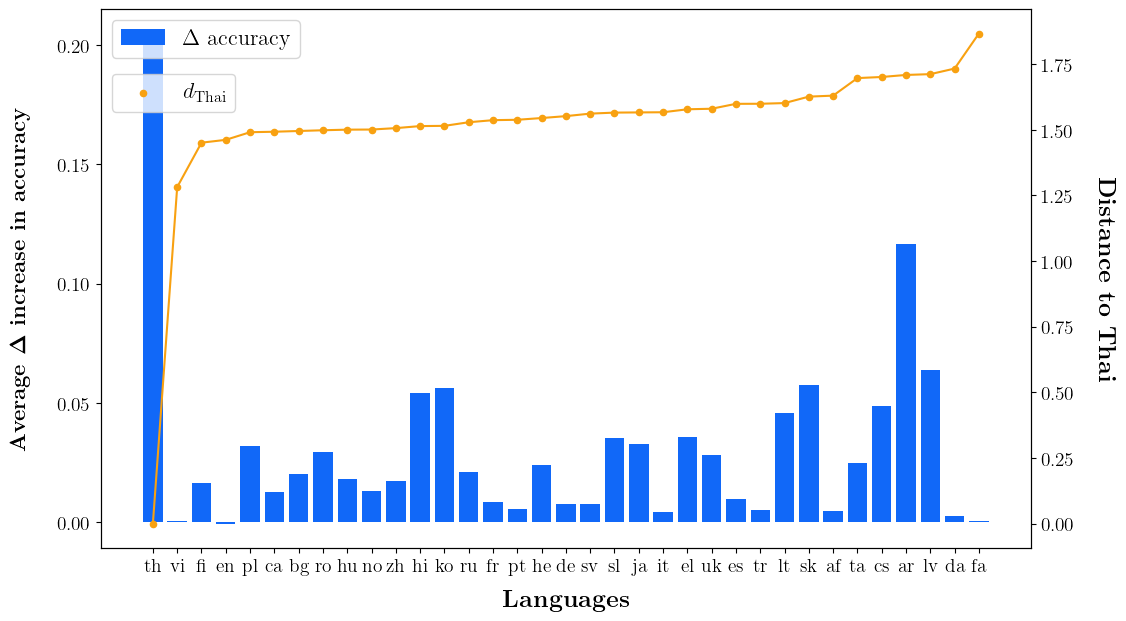

In [176]:
df = average_delta_accuracy.sort_values(by="distance_to_thai")
df = df.drop(index=[0]) # drop Thai to make the plots

# Create the main figure and axis
fig, ax1 = plt.subplots(figsize=(12, 7))

# Scatter plot on the primary y-axis
ax1.bar(
    df["language"],
    df["delta_accuracy"],
    color="#1168F8",
    label=r"$\Delta$ accuracy",
)
ax1.set_xlabel(r"\textbf{Languages}", fontsize=18, labelpad=10)
ax1.set_ylabel(
    r"\textbf{Average $\bm{\Delta}$ increase in accuracy}",
    color="black",
    fontsize=16,
    rotation=90,
    labelpad=20,
)

# Set the font size for the x-axis and y-axis tick labels
ax1.tick_params(axis="x", labelsize=14)  # Adjust xticks font size
ax1.tick_params(axis="y", labelsize=14)  # Adjust yticks font size

# Create a secondary y-axis
ax2 = ax1.twinx()
ax2.scatter(
    df["language"],
    df["distance_to_thai"],
    color="#F8A111",
    s=20,
    label=r"$d_{\text{Thai}}$",
)
ax2.plot(
    df["language"],
    df["distance_to_thai"],
    color="#F8A111",
    linestyle="-",
    marker="",
)
ax2.set_ylabel(
    r"\textbf{Distance to Thai}", 
    color="black", 
    fontsize=18, 
    rotation=270, 
    labelpad=30
)

# Set the font size for the secondary y-axis tick labels
ax2.tick_params(axis="y", labelsize=14)  # Adjust yticks font size

# Add legends
ax1.legend(loc="upper left", fontsize=16)
ax2.legend(loc="upper left", fontsize=16, bbox_to_anchor=(0, 0.90))

plt.savefig("summary_plots/distance_delta_thai.pdf", bbox_inches="tight")

# plt.legend()
plt.show()

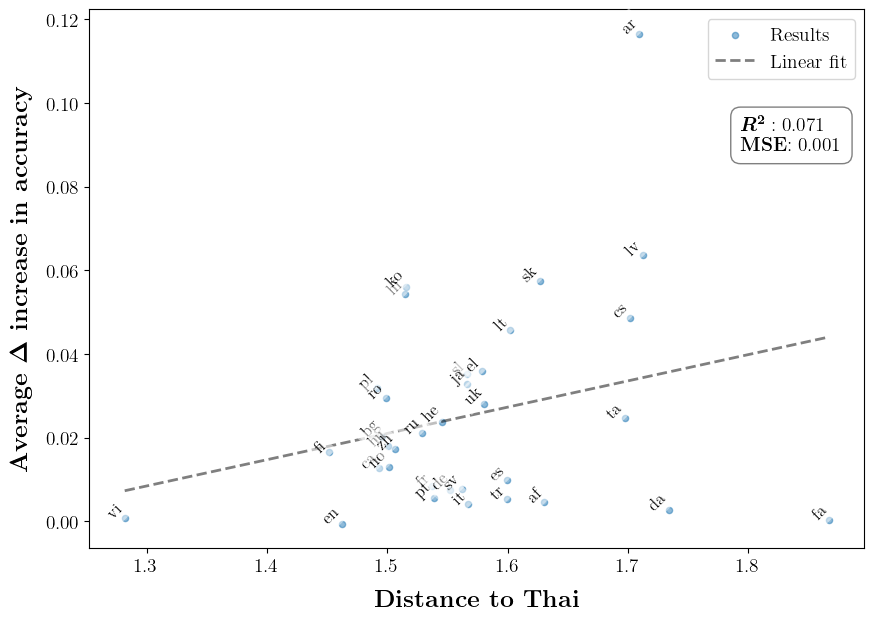

In [174]:
df = average_delta_accuracy.sort_values(by="distance_to_thai")
df = df.drop(index=[0])  # drop Thai to make the plots

X = df[["distance_to_thai"]]
y = df["delta_accuracy"]

regression_model = LinearRegression().fit(X, y)
y_pred = regression_model.predict(X)

mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)

plt.figure(figsize=(10, 7))
plt.scatter(X, y, s=20, alpha=0.5, label="Results")
# Regression line
plt.plot(X, y_pred, color="black", linewidth=2, linestyle="--", alpha=0.5, label="Linear fit")  # Red line for the prediction

plt.xlabel(
    r"\textbf{Distance to Thai}", 
    fontsize=18, 
    labelpad=10
)
plt.ylabel(
    r"\textbf{Average $\bm{\Delta}$ increase in accuracy}", 
    fontsize=18, 
    labelpad=10
)

text = f"$\\bm{{R^2}}:$ {r2:.3f}\n\\textbf{{MSE}}: {mse:.3f}"
plt.text(
    0.84,
    0.80,
    r"{}".format(text),
    transform=plt.gca().transAxes,
    verticalalignment="top",
    bbox=dict(boxstyle="round,pad=0.5", edgecolor="gray", facecolor="white"),
    fontsize=14
)

for i in df.index:
    plt.text(
        x=df.distance_to_thai[i],
        y=df.delta_accuracy[i],
        s=df.language[i],
        fontdict=dict(color="black", size=12),
        rotation=45,
        horizontalalignment="right",
        bbox=dict(facecolor="white", alpha=0.5, edgecolor="none"),
    )

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.legend(fontsize=14, loc="upper right")

plt.savefig("regression_plots/thai-distance-accuracy-scatterplot-withoutThai.pdf")
plt.show()

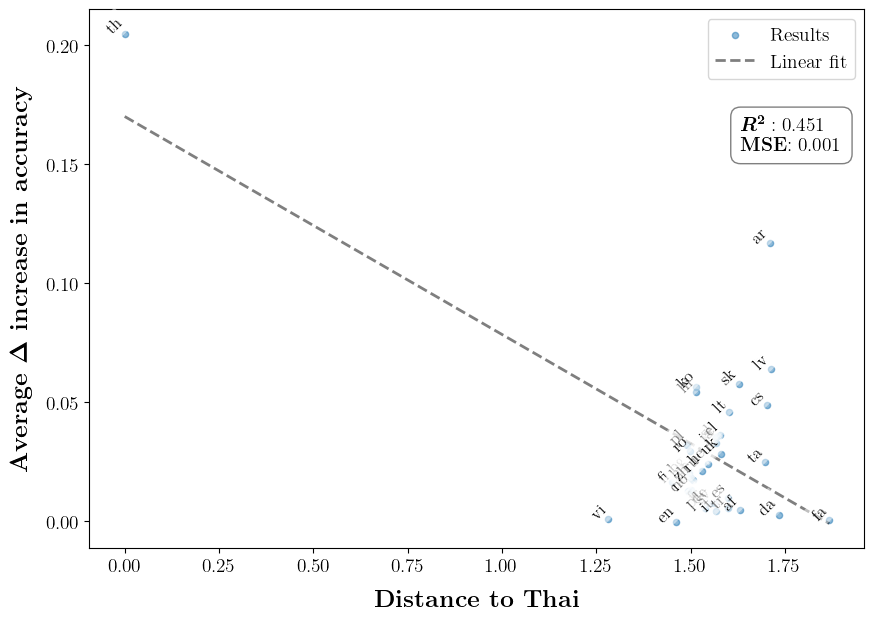

In [173]:
df = average_delta_accuracy.sort_values(by="distance_to_thai")
# df = df.drop(index=[0])  # drop Thai to make the plots

X = df[["distance_to_thai"]]
y = df["delta_accuracy"]

regression_model = LinearRegression().fit(X, y)
y_pred = regression_model.predict(X)

mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)

plt.figure(figsize=(10, 7))
plt.scatter(X, y, s=20, alpha=0.5, label="Results")
# Regression line
plt.plot(X, y_pred, color="black", linewidth=2, linestyle="--", alpha=0.5, label="Linear fit")  # Red line for the prediction

plt.xlabel(
    r"\textbf{Distance to Thai}", 
    fontsize=18, 
    labelpad=10
)
plt.ylabel(
    r"\textbf{Average $\bm{\Delta}$ increase in accuracy}", 
    fontsize=18, 
    labelpad=10
)


text = f"$\\bm{{R^2}}:$ {r2:.3f}\n\\textbf{{MSE}}: {mse:.3f}"
plt.text(
    0.84,
    0.80,
    r"{}".format(text),
    transform=plt.gca().transAxes,
    verticalalignment="top",
    bbox=dict(boxstyle="round,pad=0.5", edgecolor="gray", facecolor="white"),
    fontsize=14
)

for i in df.index:
    plt.text(
        x=df.distance_to_thai[i],
        y=df.delta_accuracy[i],
        s=df.language[i],
        fontdict=dict(color="black", size=12),
        rotation=45,
        horizontalalignment="right",
        bbox=dict(facecolor="white", alpha=0.5, edgecolor="none"),
    )

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.legend(fontsize=14, loc="upper right")

plt.savefig("regression_plots/thai-distance-accuracy-scatterplot.pdf")
plt.show()

In [71]:
# # Filter for distilMBERT model
# distilbert_df = combined_df_with_flags[combined_df_with_flags['model'] == 'distilMBERT']

# # Calculate the nearest neighbors to Thai
# nearest_neighbors_df = find_nearest_neighbors('Thai', uri_data, n_neighbors=34)

# # Get the list of similar languages to Thai (including Thai itself for reference)
# similar_language_names = nearest_neighbors_df['language'].tolist() + ['Thai']

# # Filter the original dataframe for these languages to get their Delta accuracy
# delta_accuracy_df = distilbert_df[distilbert_df['language'].isin(similar_language_names)]
# average_delta_accuracy = delta_accuracy_df.groupby('language')['delta_accuracy'].mean().reset_index()

# # Get the coordinates for Thai
# thai_coordinates = find_closest_coordinates(uri_data, gc_columns)['Thai']
# thai_lat, thai_lon = extract_coordinates(thai_coordinates)

# # Create a DataFrame for Thai's coordinates
# thai_df = pd.DataFrame([{
#     'language': 'Thai',
#     'Distance': 0.0,
#     'Nearest_Coordinate_Column': thai_coordinates,
#     'Latitude': thai_lat,
#     'Longitude': thai_lon
# }])

# # Add Thai's coordinates to the nearest_neighbors_df
# nearest_neighbors_df = pd.concat([nearest_neighbors_df, thai_df], ignore_index=True)

# # Merge the distances with average delta accuracy
# average_delta_accuracy = average_delta_accuracy.merge(nearest_neighbors_df, on='language', how='left')

# # Ensure the average_delta_accuracy dataframe maintains the same order
# average_delta_accuracy = average_delta_accuracy.sort_values(by='Distance')

# # Display the results
# average_delta_accuracy


In [72]:
# import folium

# def create_map(data, language_of_interest):
#     # Create a map centered around the first coordinate
#     m = folium.Map(location=[data.iloc[0]['Latitude'], data.iloc[0]['Longitude']], zoom_start=2)

#     # Add the language of interest
#     folium.Marker(
#         [data[data['language'] == language_of_interest]['Latitude'].values[0], 
#          data[data['language'] == language_of_interest]['Longitude'].values[0]], 
#          popup=f"{language_of_interest} (Target)",
#          icon=folium.Icon(color='red')
#     ).add_to(m)

#     # Add the other languages
#     for i, row in data.iterrows():
#         if row['language'] != language_of_interest:
#             folium.Marker(
#                 [row['Latitude'], row['Longitude']],
#                 popup=f"{row['language']} ({row['Distance']:.2f})",
#                 icon=folium.Icon(color='blue')
#             ).add_to(m)
    
#     return m

# # Assuming average_delta_accuracy is your DataFrame
# create_map(average_delta_accuracy, 'Thai')


In [75]:
# # Combine the distance and delta accuracy data into a single dataframe
# heatmap_data = pd.merge(
#     similar_languages[["language", "distance_to_thai"]],
#     average_delta_accuracy[["language", "delta_accuracy"]],
#     on="language",
# )

# # Add language family information to the heatmap_data dataframe
# language_families = {
#     "Thai": "Tai-Kadai",
#     "Vietnamese": "Austroasiatic",
#     "Finnish": "Uralic",
#     "English": "Indo-European",
#     "Polish": "Indo-European",
#     "Catalan": "Indo-European",
#     "Bulgarian": "Indo-European",
#     "Romanian": "Indo-European",
#     "Hungarian": "Uralic",
#     "Norwegian": "Indo-European",
#     "Chinese": "Sino-Tibetan",
# }
# heatmap_data["language_family"] = heatmap_data["language"].map(language_families)

# # Get Thai's delta accuracy
# thai_delta_accuracy = heatmap_data[heatmap_data["language"] == "Thai"]["delta_accuracy"].values[0]

# # Remove Thai from the heatmap data
# heatmap_data = heatmap_data[heatmap_data["language"] != "Thai"]

# # Sort the dataframe by language family and distance to Thai
# heatmap_data = heatmap_data.sort_values(["language_family", "distance_to_thai"])

# # Create a pivot table with language families as rows and languages as columns
# heatmap_pivot = heatmap_data.pivot(
#     index="language_family", columns="language", values="distance_to_thai"
# )

# # Create a custom colormap with a simple blue to red color scheme
# cmap = sns.color_palette("coolwarm", as_cmap=True)
# cmap.set_bad("lightgray")

# # LinearMap with a blue color like the one from UofT/OntarioTech and its complementary color
# cmap=LinearSegmentedColormap.from_list("custom", ["#2F7BF9", "#F9AD2F"])
# cmap.set_bad("lightgray")

# # Create the heatmap
# plt.figure(figsize=(12, 6))
# sns.heatmap(
#     heatmap_pivot,
#     annot=False,
#     cmap=cmap,
#     cbar_kws={"label": "Euclidean Distance"},
#     square=True,
#     linewidths=0.5,
#     linecolor="black",
#     mask=heatmap_pivot.isnull(),
# )

# # Add delta accuracy values as percentages inside each square
# for i in range(heatmap_pivot.shape[0]):
#     for j in range(heatmap_pivot.shape[1]):
#         language = heatmap_pivot.columns[j]
#         if not pd.isnull(heatmap_pivot.iloc[i, j]):
#             delta_accuracy = heatmap_data[heatmap_data["language"] == language][
#                 "delta_accuracy"
#             ].values[0]
#             value = f"{delta_accuracy*100:.2f}\%"
#             plt.text(
#                 j + 0.5,
#                 i + 0.5,
#                 r"\textbf{{ {} }}".format(value),
#                 ha="center",
#                 va="center",
#                 color="black",
#                 fontsize=11,
#             )

# # Adjust the plot layout
# plt.yticks(rotation=0)
# plt.xticks(rotation=45, ha="right")
# plt.title(r"\textbf{10 Nearest Neighbors to Thai: Euclidean Distance of Lang2Vec Distance Features}", fontsize=16)
# plt.xlabel(r"\textbf{Language}", fontsize=16)
# plt.ylabel(r"\textbf{Language Family}", fontsize=16)

# # Add Thai's delta accuracy below the title with reduced vertical gap
# print(f"Thai (Tai-Kadai)\nDelta Accuracy: {thai_delta_accuracy*100:.2f}\%")
# plt.suptitle(
#     r"\textbf{Thai (Tai-Kadai) $\bm{\Delta}$ Accuracy: 20.64\%}",
#     fontsize=12,
#     y=0.88,
# )

# plt.tight_layout()
# plt.subplots_adjust(top=0.92)  # Adjust the top spacing to minimize the gap

# plt.savefig("regression_plots/thai_neighbors_heatmap.pdf", bbox_inches="tight")
# plt.show()

### Regression

In [ ]:
delta_accuracy_df

In [ ]:
nli_csv_path = './distilMBERT_nli_data/distilbert-base-multilingual-cased__xnli__opus100.csv'

nli_df = read_and_process_csv(nli_csv_path, model_name='distilMBERT')
nli_df = nli_df[~nli_df.isna().any(axis=1)]

In [ ]:
nli_df

In [ ]:
nli_df['method'].value_counts()

In [ ]:
processed_nli_df = process_dataframe(nli_df, group_by_columns=['model', 'seed', 'language'])

In [ ]:
processed_nli_df

In [ ]:
processed_nli_df[(processed_nli_df['language'] == 'Chinese') & (processed_nli_df['seed'] == 17)]

In [ ]:
processed_nli_df = processed_nli_df[~processed_nli_df.isna().any(axis=1)]

In [ ]:
# Calculate average and standard error of delta accuracy grouped by method
average_delta_accuracy = processed_nli_df.groupby('method')['delta_accuracy'].agg(['mean', 'sem']).reset_index()

# Set up the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Create the x-axis positions
x_pos = np.arange(len(average_delta_accuracy))

# Define the color for distilMBERT
distilMBERT_color = '#ff7f0e'

# Plot bars for each method
ax.bar(x_pos, average_delta_accuracy['mean'], yerr=average_delta_accuracy['sem'], align='center', alpha=0.7, ecolor='black', capsize=10, color=distilMBERT_color)

# Set the x-axis tick positions and labels
ax.set_xticks(x_pos)
ax.set_xticklabels([method.replace('_', ' ') for method in average_delta_accuracy['method']], rotation=45, ha='right')

# Set the plot title and labels
ax.set_title('Average Delta Accuracy by Method for distilMBERT on NLI')
ax.set_xlabel('Method')
ax.set_ylabel('Average Delta Accuracy')

# Add grid lines
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Improve the layout
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
nli_train_data, nli_val_data, nli_test_data = split_train_val_test(processed_nli_df, use_standard_split=True)

In [ ]:
nli_train_data

In [ ]:
nli_val_data

In [ ]:
nli_test_data

In [ ]:
nli_coefficients, nli_encoded_columns = perform_regression(nli_train_data, nli_val_data, nli_test_data)

plot_feature_importances(nli_coefficients, nli_encoded_columns)

In [ ]:
processed_nli_df_with_distances = add_language_distances_to_df(processed_nli_df)

In [ ]:
processed_nli_df_with_distances

In [ ]:
processed_nli_df_with_distances = processed_nli_df_with_distances[~processed_nli_df_with_distances.isna().any(axis=1)]

In [ ]:
nli_train_data, nli_val_data, nli_test_data = split_train_val_test(processed_nli_df_with_distances, use_standard_split=True)

In [ ]:
nli_train_data

In [ ]:
nli_val_data

In [ ]:
nli_test_data

In [ ]:
nli_dist_coefficients, nli_dist_encoded_columns = perform_regression(nli_train_data, nli_val_data, nli_test_data)

plot_feature_importances(nli_dist_coefficients, nli_dist_encoded_columns, group_by_distance=True)

In [ ]:
nli_df_flagged = flag_freeze_methods(processed_nli_df_with_distances)

In [ ]:
nli_df_flagged = nli_df_flagged[~nli_df_flagged.isna().any(axis=1)]
nli_df_flagged

In [ ]:
run_regression_and_plot(nli_df_flagged, "Using all data")

# Freeze methods only
freeze_df = nli_df_flagged[nli_df_flagged['method_type'] == 'freeze']
run_regression_and_plot(freeze_df, "Using freeze methods only")

# Vanilla methods only
vanilla_df = nli_df_flagged[nli_df_flagged['method_type'] == 'vanilla']
run_regression_and_plot(vanilla_df, "Using vanilla methods only")

## Tables

In [ ]:
import pandas as pd

# Load the CSV file
file_path = './distilMBERT_percentile_data/distilbert-base-multilingual-cased__opus100.csv'
data = pd.read_csv(file_path)

# Define the shortened method names dictionary
shortened_method_names = {
    'baseline': 'FT Only',
    'before_fastalign': 'Before FA',
    'before_awesome': 'Before AA',
    'before_dico': 'Before BD',
    'during_fastalign': 'During FA',
    'during_awesome': 'During AA',
    'during_dico': 'During BD',
}

# Define the language codes to full names mapping
language_names = {
    'af': 'Afrikaans',
    'ar': 'Arabic',
    'avg': 'Average',
    'bg': 'Bulgarian',
    'ca': 'Catalan',
    'zh': 'Chinese',
    'cs': 'Czech',
    'da': 'Danish',
    'fi': 'Finnish',
    'fr': 'French',
    'de': 'German',
    'el': 'Greek',
    'he': 'Hebrew',
    'hi': 'Hindi',
    'hu': 'Hungarian',
    'it': 'Italian',
    'ja': 'Japanese',
    'ko': 'Korean',
    'lv': 'Latvian',
    'lt': 'Lithuanian',
    'no': 'Norwegian',
    'fa': 'Persian',
    'pl': 'Polish',
    'pt': 'Portuguese',
    'ro': 'Romanian',
    'ru': 'Russian',
    'sk': 'Slovak',
    'sl': 'Slovenian',
    'es': 'Spanish',
    'sv': 'Swedish',
    'ta': 'Tamil',
    'th': 'Thai',
    'tr': 'Turkish',
    'uk': 'Ukrainian',
    'vi': 'Vietnamese'
}

# Extract accuracy columns
accuracy_cols = [col for col in data.columns if 'final_eval_' in col and 'accuracy' in col]

# Melting the dataframe to get a long format
long_data = data.melt(id_vars=['method'], value_vars=accuracy_cols, var_name='language', value_name='accuracy')

# Cleaning up the language column
long_data['language'] = long_data['language'].str.replace('final_eval_', '').str.replace('_accuracy', '')
long_data['language'] = long_data['language'].map(language_names)

# Updating method names with shortened versions
long_data['method'] = long_data['method'].map(shortened_method_names).fillna('FT Only')

# Extracting method components
long_data[['timing', 'aligner']] = long_data['method'].str.extract(r'(FT Only|Before|During)\s*(AA|BD|FA)?')

# Ensure 'FT Only' has empty aligner value
long_data.loc[long_data['timing'] == 'FT Only', 'aligner'] = ''

# Pivot the data to create the table
pivot_data = long_data.pivot_table(index='language', columns=['timing', 'aligner'], values='accuracy', aggfunc='mean')

# Reorder the columns
column_order = [
    ('FT Only', ''),
    ('Before', 'AA'),
    ('Before', 'BD'),
    ('Before', 'FA'),
    ('During', 'AA'),
    ('During', 'BD'),
    ('During', 'FA')
]
pivot_data = pivot_data.reindex(columns=column_order)

# Round the values to 3 decimal places and highlight the maximum in each row
def format_and_highlight(data):
    formatted_data = data.applymap(lambda x: f'{x:.3f}' if pd.notna(x) else '')
    for idx in formatted_data.index:
        max_value = data.loc[idx].max()
        if pd.notna(max_value):
            formatted_data.loc[idx] = formatted_data.loc[idx].apply(lambda x: f'\\textbf{{{x}}}' if x == f'{max_value:.3f}' else x)
    return formatted_data

highlighted_data = format_and_highlight(pivot_data)

# Create the LaTeX table
table_header = r"""
\onecolumn
\begin{table*}[ht]
\centering
\begin{tabular}{|l|c|ccc|ccc|}
\hline
Train. Appr. & FT Only & \multicolumn{3}{c|}{Before} & \multicolumn{3}{c|}{During} \\ \cline{3-8}
Aligner & & AA & BD & FA & AA & BD & FA \\
\hline
"""

table_footer = r"""
\hline
\end{tabular}
\caption{PoS tagging average accuracy results across 5 seeds using distilMBERT for the vanilla methods by language, training approach, and aligner. Aligner names: FA - FastAlign, AA - AwesomeAlign, BD - Bilingual Dictionaries. The highest average accuracy value for each language is highlighted in bold.}
\label{table:vanilla_accuracy_results}
\end{table*}
\twocolumn
"""

# Combine the table data
table_body = ""
for index, row in highlighted_data.iterrows():
    row_data = " & ".join(row)
    table_body += f"{index} & {row_data} \\\\\n"

latex_table = table_header + table_body + table_footer

print(latex_table)


In [9]:
import pandas as pd

# Load the CSV file
file_path = './xlmr_threshold_data/opus100_filtered_0.8.csv'
data = pd.read_csv(file_path)

# Define the shortened method names dictionary including freeze methods
shortened_method_names = {
    'baseline': 'FT Only',
    'before_fastalign': 'Before FA',
    'before_awesome': 'Before AA',
    'before_dico': 'Before BD',
    'during_fastalign': 'During FA',
    'during_awesome': 'During AA',
    'during_dico': 'During BD',
    'freeze_realign_unfreeze_fastalign': 'Front Freeze Before FA',
    'freeze_realign_unfreeze_awesome': 'Front Freeze Before AA',
    'freeze_realign_unfreeze_dico': 'Front Freeze Before BD',
    'freeze_realign_unfreeze_last_half_fastalign': 'Back Freeze Before FA',
    'freeze_realign_unfreeze_last_half_awesome': 'Back Freeze Before AA',
    'freeze_realign_unfreeze_last_half_dico': 'Back Freeze Before BD',
    'freeze_realign_unfreeze_last_6_fastalign': 'Back Freeze Before FA',
    'freeze_realign_unfreeze_last_6_awesome': 'Back Freeze Before AA',
    'freeze_realign_unfreeze_last_6_dico': 'Back Freeze Before BD',
    'during_partial_freeze_front_fastalign': 'Front Freeze During FA',
    'during_partial_freeze_front_awesome': 'Front Freeze During AA',
    'during_partial_freeze_front_dico': 'Front Freeze During BD',
    'during_partial_freeze_back_fastalign': 'Back Freeze During FA',
    'during_partial_freeze_back_awesome': 'Back Freeze During AA',
    'during_partial_freeze_back_dico': 'Back Freeze During BD'
}

# Define the language codes to full names mapping
language_names = {
    'af': 'Afrikaans',
    'ar': 'Arabic',
    'avg': 'Average',
    'bg': 'Bulgarian',
    'ca': 'Catalan',
    'zh': 'Chinese',
    'cs': 'Czech',
    'da': 'Danish',
    'fi': 'Finnish',
    'fr': 'French',
    'de': 'German',
    'el': 'Greek',
    'he': 'Hebrew',
    'hi': 'Hindi',
    'hu': 'Hungarian',
    'it': 'Italian',
    'ja': 'Japanese',
    'ko': 'Korean',
    'lv': 'Latvian',
    'lt': 'Lithuanian',
    'no': 'Norwegian',
    'fa': 'Persian',
    'pl': 'Polish',
    'pt': 'Portuguese',
    'ro': 'Romanian',
    'ru': 'Russian',
    'sk': 'Slovak',
    'sl': 'Slovenian',
    'es': 'Spanish',
    'sv': 'Swedish',
    'ta': 'Tamil',
    'th': 'Thai',
    'tr': 'Turkish',
    'uk': 'Ukrainian',
    'vi': 'Vietnamese'
}

# Extract accuracy columns
accuracy_cols = [col for col in data.columns if 'final_eval_' in col and 'accuracy' in col]

# Melting the dataframe to get a long format
long_data = data.melt(id_vars=['method'], value_vars=accuracy_cols, var_name='language', value_name='accuracy')

# Cleaning up the language column
long_data['language'] = long_data['language'].str.replace('final_eval_', '').str.replace('_accuracy', '')
long_data['language'] = long_data['language'].map(language_names)

# Updating method names with shortened versions
long_data['method'] = long_data['method'].map(shortened_method_names).fillna('FT Only')

# Extracting method components
long_data[['primary_group', 'timing', 'aligner']] = long_data['method'].str.extract(r'(FT Only|Front Freeze|Back Freeze)?\s*(Before|During)?\s*(AA|BD|FA)?')

# Ensure 'FT Only' has empty primary_group, timing, and aligner values
long_data.loc[long_data['method'] == 'FT Only', ['primary_group', 'timing', 'aligner']] = ['FT Only', '', '']

# Pivot the data to create the table
pivot_data = long_data.pivot_table(index='language', columns=['primary_group', 'timing', 'aligner'], values='accuracy', aggfunc='mean')

# Reorder the columns
column_order = [
    ('FT Only', '', ''),
    ('Front Freeze', 'Before', 'AA'),
    ('Front Freeze', 'Before', 'BD'),
    ('Front Freeze', 'Before', 'FA'),
    ('Front Freeze', 'During', 'AA'),
    ('Front Freeze', 'During', 'BD'),
    ('Front Freeze', 'During', 'FA'),
    ('Back Freeze', 'Before', 'AA'),
    ('Back Freeze', 'Before', 'BD'),
    ('Back Freeze', 'Before', 'FA'),
    ('Back Freeze', 'During', 'AA'),
    ('Back Freeze', 'During', 'BD'),
    ('Back Freeze', 'During', 'FA')
]
pivot_data = pivot_data.reindex(columns=column_order)

# Round the values to 3 decimal places and highlight the maximum in each row
def format_and_highlight(data):
    formatted_data = data.applymap(lambda x: f'{x:.3f}' if pd.notna(x) else '')
    for idx in formatted_data.index:
        max_value = data.loc[idx].max()
        if pd.notna(max_value):
            formatted_data.loc[idx] = formatted_data.loc[idx].apply(lambda x: f'\\textbf{{{x}}}' if x == f'{max_value:.3f}' else x)
    return formatted_data

highlighted_data = format_and_highlight(pivot_data)

# Create the LaTeX table using tabularx and centering "Aligner"
table_header = r"""
\usepackage{tabularx}
\onecolumn
\begin{table*}[ht]
\centering
\scriptsize
\begin{tabularx}{\textwidth}{|l|c|X|X|X|X|X|X|X|X|X|X|X|X|X|}
\hline
Train. Appr. & FT Only & \multicolumn{6}{c|}{Front Freeze} & \multicolumn{6}{c|}{Back Freeze} \\ \cline{3-14}
& & \multicolumn{3}{c|}{Before} & \multicolumn{3}{c|}{During} & \multicolumn{3}{c|}{Before} & \multicolumn{3}{c|}{During} \\ \cline{3-14}
Aligner & & \multicolumn{1}{c|}{AA} & \multicolumn{1}{c|}{BD} & \multicolumn{1}{c|}{FA} & \multicolumn{1}{c|}{AA} & \multicolumn{1}{c|}{BD} & \multicolumn{1}{c|}{FA} & \multicolumn{1}{c|}{AA} & \multicolumn{1}{c|}{BD} & \multicolumn{1}{c|}{FA} & \multicolumn{1}{c|}{AA} & \multicolumn{1}{c|}{BD} & \multicolumn{1}{c|}{FA} \\
\hline
"""

table_footer = r"""
\hline
\end{tabularx}
\caption{PoS tagging average accuracy results across 5 seeds using distilMBERT for the freeze methods by language, training approach, and aligner. Aligner names: FA - FastAlign, AA - AwesomeAlign, BD - Bilingual Dictionaries. The highest average accuracy value for each language is highlighted in bold.}
\label{table:vanilla_accuracy_results}
\end{table*}
\twocolumn
"""

# Combine the table data
table_body = ""
for index, row in highlighted_data.iterrows():
    row_data = " & ".join(row)
    table_body += f"{index} & {row_data} \\\\\n"

latex_table = table_header + table_body + table_footer

print(latex_table)



\usepackage{tabularx}
\onecolumn
\begin{table*}[ht]
\centering
\scriptsize
\begin{tabularx}{\textwidth}{|l|c|X|X|X|X|X|X|X|X|X|X|X|X|X|}
\hline
Train. Appr. & FT Only & \multicolumn{6}{c|}{Front Freeze} & \multicolumn{6}{c|}{Back Freeze} \\ \cline{3-14}
& & \multicolumn{3}{c|}{Before} & \multicolumn{3}{c|}{During} & \multicolumn{3}{c|}{Before} & \multicolumn{3}{c|}{During} \\ \cline{3-14}
Aligner & & \multicolumn{1}{c|}{AA} & \multicolumn{1}{c|}{BD} & \multicolumn{1}{c|}{FA} & \multicolumn{1}{c|}{AA} & \multicolumn{1}{c|}{BD} & \multicolumn{1}{c|}{FA} & \multicolumn{1}{c|}{AA} & \multicolumn{1}{c|}{BD} & \multicolumn{1}{c|}{FA} & \multicolumn{1}{c|}{AA} & \multicolumn{1}{c|}{BD} & \multicolumn{1}{c|}{FA} \\
\hline
Arabic & 0.592 & 0.609 & 0.606 & 0.602 &  &  &  & \textbf{0.622} & 0.602 & 0.614 &  &  &  \\
Average & 0.601 & 0.628 & 0.628 & 0.625 &  &  &  & \textbf{0.638} & 0.631 & 0.629 &  &  &  \\
Bulgarian & 0.634 & 0.656 & 0.650 & 0.650 &  &  &  & \textbf{0.658} & \textbf{0.658} & 0

C:\Users\alith\AppData\Local\Temp\ipykernel_23992\2062577866.py:114: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  formatted_data = data.applymap(lambda x: f'{x:.3f}' if pd.notna(x) else '')


In [13]:
import pandas as pd

# Load the CSV file
file_path = './distilMBERT_nli_data/distilbert-base-multilingual-cased__xnli__opus100_filtered_percent_50.csv'
data = pd.read_csv(file_path)

# Define the shortened method names dictionary including freeze methods, excluding "during" methods
shortened_method_names = {
    'baseline': 'FT Only',
    'before_fastalign': 'Before FA',
    'before_awesome': 'Before AA',
    'before_dico': 'Before BD',
    'freeze_realign_unfreeze_fastalign': 'Front Freeze Before FA',
    'freeze_realign_unfreeze_awesome': 'Front Freeze Before AA',
    'freeze_realign_unfreeze_dico': 'Front Freeze Before BD',
    'freeze_realign_unfreeze_last_half_fastalign': 'Back Freeze Before FA',
    'freeze_realign_unfreeze_last_half_awesome': 'Back Freeze Before AA',
    'freeze_realign_unfreeze_last_half_dico': 'Back Freeze Before BD',
    'freeze_realign_unfreeze_last_6_fastalign': 'Back Freeze Before FA',
    'freeze_realign_unfreeze_last_6_awesome': 'Back Freeze Before AA',
    'freeze_realign_unfreeze_last_6_dico': 'Back Freeze Before BD'
}

# Define the language codes to full names mapping
language_names = {
    'af': 'Afrikaans',
    'ar': 'Arabic',
    'avg': 'Average',
    'bg': 'Bulgarian',
    'ca': 'Catalan',
    'zh': 'Chinese',
    'cs': 'Czech',
    'da': 'Danish',
    'fi': 'Finnish',
    'fr': 'French',
    'de': 'German',
    'el': 'Greek',
    'he': 'Hebrew',
    'hi': 'Hindi',
    'hu': 'Hungarian',
    'it': 'Italian',
    'ja': 'Japanese',
    'ko': 'Korean',
    'lv': 'Latvian',
    'lt': 'Lithuanian',
    'no': 'Norwegian',
    'fa': 'Persian',
    'pl': 'Polish',
    'pt': 'Portuguese',
    'ro': 'Romanian',
    'ru': 'Russian',
    'sk': 'Slovak',
    'sl': 'Slovenian',
    'es': 'Spanish',
    'sv': 'Swedish',
    'ta': 'Tamil',
    'th': 'Thai',
    'tr': 'Turkish',
    'uk': 'Ukrainian',
    'vi': 'Vietnamese'
}

# Extract accuracy columns
accuracy_cols = [col for col in data.columns if 'final_eval_' in col and 'accuracy' in col]

# Melting the dataframe to get a long format
long_data = data.melt(id_vars=['method'], value_vars=accuracy_cols, var_name='language', value_name='accuracy')

# Cleaning up the language column
long_data['language'] = long_data['language'].str.replace('final_eval_', '').str.replace('_accuracy', '')
long_data['language'] = long_data['language'].map(language_names)

# Updating method names with shortened versions
long_data['method'] = long_data['method'].map(shortened_method_names).fillna('FT Only')

# Extracting method components
long_data[['primary_group', 'timing', 'aligner']] = long_data['method'].str.extract(r'(FT Only|Front Freeze|Back Freeze)?\s*(Before)?\s*(AA|BD|FA)?')

# Ensure 'FT Only' has empty primary_group, timing, and aligner values
long_data.loc[long_data['method'] == 'FT Only', ['primary_group', 'timing', 'aligner']] = ['FT Only', '', '']

# Pivot the data to create the table
pivot_data = long_data.pivot_table(index='language', columns=['primary_group', 'timing', 'aligner'], values='accuracy', aggfunc='mean')

# Reorder the columns
column_order = [
    ('FT Only', '', ''),
    ('Front Freeze', 'Before', 'AA'),
    ('Front Freeze', 'Before', 'BD'),
    ('Front Freeze', 'Before', 'FA'),
    ('Back Freeze', 'Before', 'AA'),
    ('Back Freeze', 'Before', 'BD'),
    ('Back Freeze', 'Before', 'FA')
]
pivot_data = pivot_data.reindex(columns=column_order)

# Round the values to 3 decimal places and highlight the maximum in each row
def format_and_highlight(data):
    formatted_data = data.applymap(lambda x: f'{x:.3f}' if pd.notna(x) else '')
    for idx in formatted_data.index:
        max_value = data.loc[idx].max()
        if pd.notna(max_value):
            formatted_data.loc[idx] = formatted_data.loc[idx].apply(lambda x: f'\\textbf{{{x}}}' if x == f'{max_value:.3f}' else x)
    return formatted_data

highlighted_data = format_and_highlight(pivot_data)

# Create the LaTeX table using tabularx and centering "Aligner"
table_header = r"""
\usepackage{tabularx}
\usepackage{geometry}
\geometry{margin=1in}
\onecolumn
\begin{table*}[ht]
\centering
\scriptsize
\begin{tabular}{|l|c|c|c|c|c|c|c|c|}
\hline
Train. Appr. & FT Only & \multicolumn{3}{c|}{Front Freeze} & \multicolumn{3}{c|}{Back Freeze} \\ \cline{3-8}
& & \multicolumn{3}{c|}{Before} & \multicolumn{3}{c|}{Before} \\ \cline{3-8}
Aligner & & \multicolumn{1}{c|}{AA} & \multicolumn{1}{c|}{BD} & \multicolumn{1}{c|}{FA} & \multicolumn{1}{c|}{AA} & \multicolumn{1}{c|}{BD} & \multicolumn{1}{c|}{FA} \\
\hline
"""

table_footer = r"""
\hline
\end{tabular}
\caption{NLI average accuracy results across 5 seeds using distilMBERT for the freeze methods by language, training approach, and aligner. Aligner names: FA - FastAlign, AA - AwesomeAlign, BD - Bilingual Dictionaries. The highest average accuracy value for each language is highlighted in bold.}
\label{table:vanilla_accuracy_results}
\end{table*}
\twocolumn
"""

# Combine the table data
table_body = ""
for index, row in highlighted_data.iterrows():
    row_data = " & ".join(row)
    table_body += f"{index} & {row_data} \\\\\n"

latex_table = table_header + table_body + table_footer

print(latex_table)



\usepackage{tabularx}
\usepackage{geometry}
\geometry{margin=1in}
\onecolumn
\begin{table*}[ht]
\centering
\scriptsize
\begin{tabular}{|l|c|c|c|c|c|c|c|c|}
\hline
Train. Appr. & FT Only & \multicolumn{3}{c|}{Front Freeze} & \multicolumn{3}{c|}{Back Freeze} \\ \cline{3-8}
& & \multicolumn{3}{c|}{Before} & \multicolumn{3}{c|}{Before} \\ \cline{3-8}
Aligner & & \multicolumn{1}{c|}{AA} & \multicolumn{1}{c|}{BD} & \multicolumn{1}{c|}{FA} & \multicolumn{1}{c|}{AA} & \multicolumn{1}{c|}{BD} & \multicolumn{1}{c|}{FA} \\
\hline
Arabic & 0.592 & 0.610 & 0.600 & 0.607 & 0.616 & 0.596 & \textbf{0.619} \\
Average & 0.601 & 0.630 & 0.626 & 0.626 & \textbf{0.635} & 0.630 & 0.629 \\
Bulgarian & 0.634 & \textbf{0.655} & 0.649 & 0.651 & 0.654 & \textbf{0.655} & \textbf{0.655} \\
Chinese & 0.639 & 0.652 & 0.650 & \textbf{0.655} & 0.646 & 0.639 & 0.654 \\
French & 0.701 & \textbf{0.705} & 0.700 & 0.699 & 0.696 & 0.699 & 0.695 \\
German & 0.657 & \textbf{0.674} & 0.667 & 0.671 & 0.671 & 0.666 & 0.668 \\
G

C:\Users\alith\AppData\Local\Temp\ipykernel_23992\3179374372.py:99: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  formatted_data = data.applymap(lambda x: f'{x:.3f}' if pd.notna(x) else '')
